### Import lib

In [1]:
import os
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib import colors
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cmcrameri import cm

from treeconfigparser import TreeConfigParser

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import models.reg as rg
import models.seg as sg
from data.Data import Data
from include.loss import pixel_weighted_cross_entropy
from include import generators

import matplotlib_functions
matplotlib_functions.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"

Segmentation Models: using `keras` framework.


<Figure size 1800x1200 with 0 Axes>

In [2]:
def get_data(name_ds: str, scaler, mode: str):
    config = TreeConfigParser()
    config.readfiles(os.path.join(dir_res, name_ds, "config.cfg"))
    with open(os.path.join(name_ds, "tv_inds.pkl"), "rb") as handle:
        tv_inds = pickle.load(handle)
    data = Data(config, tv_inds, mode)
    data.prepare_input(scaler)
    data.prepare_output()
    return data

In [3]:
def get_model(path_w: str):
    model = keras.models.load_model(os.path.join(path_w, "weights_cp_best.h5"), compile=False)
    model.compile('adam', loss=pixel_weighted_cross_entropy)    
    return model

def get_scaler(path_w: str):
    scaler = joblib.load(os.path.join(path_w, "scaler.save"))
    return scaler

### Load model, scaler, data

In [22]:
dataset = "seg_ber_05"
weights = "seg_ber_05"

In [23]:
model = get_model(os.path.join(dir_res, weights))
scaler = get_scaler(os.path.join(dir_res, weights))
data = get_data(os.path.join(dir_res, dataset), scaler, "test")

data.x.test.shape (1152, 160, 160, 1)
data.y.test.shape (1152, 160, 160, 1)


## Evaluation

### Preparation

In [24]:
x_test = tf.convert_to_tensor(data.x.test, np.float32)
pred_test = tf.convert_to_tensor(model.predict(x_test), np.float32)
y_test = tf.convert_to_tensor(data.y.test, np.float32)
loss_test = model.evaluate(x=x_test, y=y_test, batch_size=64)
data.y.get_plume(xr.open_dataset(data.path_dataset), data.eval_shuffler)
ds = xr.open_dataset(data.path_dataset)
xco2 = np.expand_dims(ds.xco2.values, -1)

18/18 [==============================] - 2s 68ms/step - loss: 0.0691


In [37]:
idx0 = int(np.random.uniform(0,data.y.test.shape[0]*0.2))
print(model.compute_loss(y=y_test[idx0:idx0+1], y_pred=pred_test[idx0:idx0+1]).numpy())
ds_idx = ds.isel(idx_img=idx0)
print("origin:", ds_idx.point_source.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)

0.122283764
origin: smart_pBer_nBBer
time: 2015-01-19T02:00:00.000000000
emiss: [11.74756 11.82039 12.23734 11.28456 12.89882 19.8753 ]


In [38]:
idx1 = int(np.random.uniform(0,data.y.test.shape[0]*0.2))
ds_idx = ds.isel(idx_img=idx1)

print(model.compute_loss(y=y_test[idx1:idx1+1], y_pred=pred_test[idx1:idx1+1]).numpy())    
print("origin:", ds_idx.point_source.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)


0.021986255
origin: smart_pBer_nBBer
time: 2015-01-19T21:00:00.000000000
emiss: [22.74464 26.82981 27.61254 29.89569 30.09505 28.72427]


<Figure size 1800x1200 with 0 Axes>

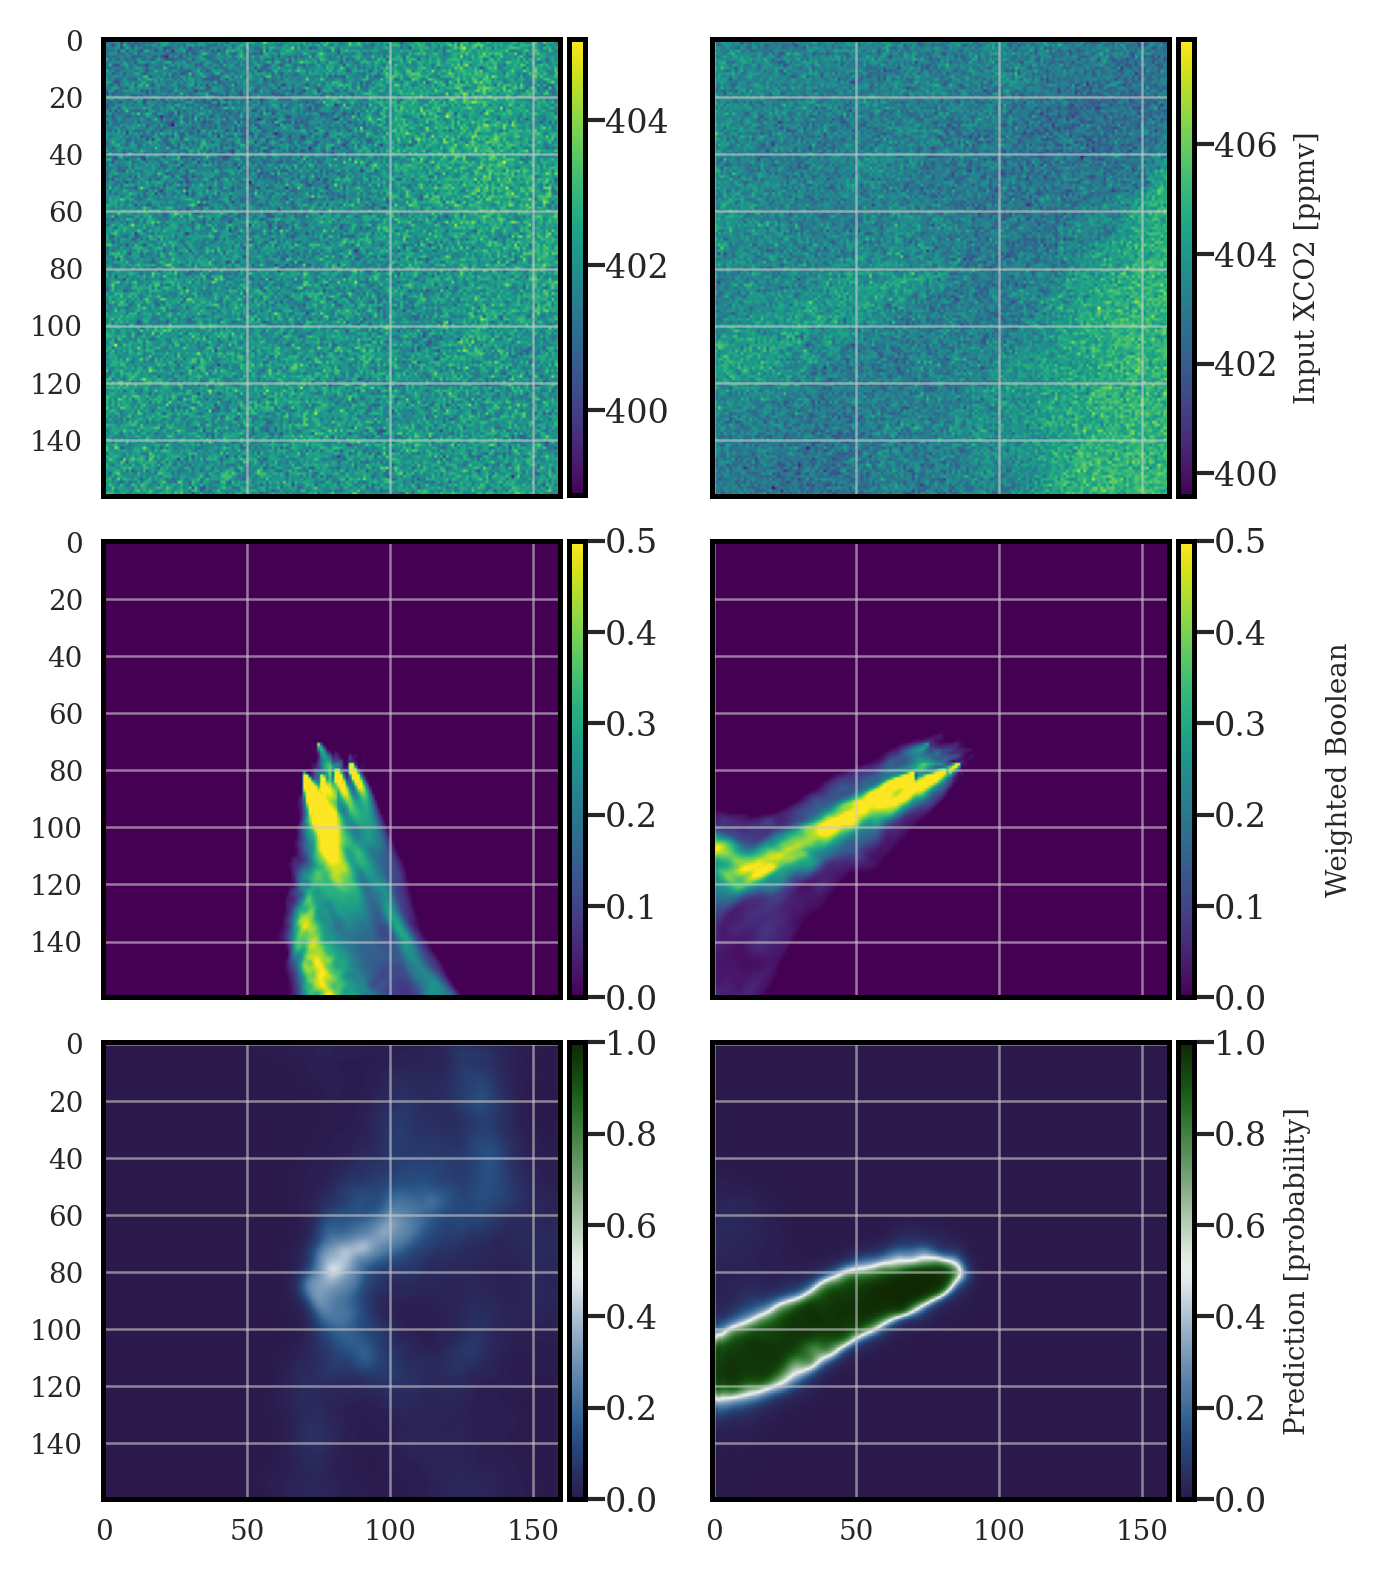

In [39]:
matplotlib_functions.setMatplotlibParam()
plt.viridis()
axs = matplotlib_functions.set_figure_axs(3, 2, wratio=0.35, hratio=0.75, pad_w_ext_left=0.25, pad_w_ext_right=0.25, pad_w_int=0.001, pad_h_ext=0.2, pad_h_int=0.15)

im0 = axs[0].imshow(scaler.inverse_transform(np.squeeze(data.x.test[idx0])))
axs[0].set_xticklabels([])
cax0 = axs[0].inset_axes((1.02, 0, 0.035, 1))
cbar0 = plt.colorbar(im0, cax0, orientation="vertical")
cbar0.ax.tick_params(labelsize="8")

im1 = axs[1].imshow(scaler.inverse_transform(np.squeeze(data.x.test[idx1])))
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
cax1 = axs[1].inset_axes((1.02, 0, 0.035, 1))
cbar1 = plt.colorbar(im1, cax1, orientation="vertical", label="Input XCO2 [ppmv]")
cbar1.ax.tick_params(labelsize="8")

im2 = axs[2].imshow(np.squeeze(data.y.test[idx0]))
axs[2].set_xticklabels([])
cax2 = axs[2].inset_axes((1.02, 0, 0.035, 1))
cbar2 = plt.colorbar(im2, cax2, orientation="vertical")
cbar2.ax.tick_params(labelsize="8")

im3 = axs[3].imshow(np.squeeze(data.y.test[idx1]))
axs[3].set_xticklabels([])
axs[3].set_yticklabels([])
cax3 = axs[3].inset_axes((1.02, 0, 0.035, 1))
cbar3 = plt.colorbar(im3, cax3, orientation="vertical")
cbar3.set_label("Weighted Boolean", labelpad=14)
cbar3.ax.tick_params(labelsize="8")

im4 = axs[4].imshow(np.squeeze(model(tf.expand_dims(data.x.test[idx0], 0))[0]), 
                    vmin=0, vmax=1, cmap = cm.cork)
cax4 = axs[4].inset_axes((1.02, 0, 0.035, 1))
cbar4 = plt.colorbar(im4, cax4, orientation="vertical")
cbar4.ax.tick_params(labelsize="8")


im5 = axs[5].imshow(np.squeeze(model(tf.expand_dims(data.x.test[idx1], 0))[0]), 
                    vmin=0, vmax=1, cmap = cm.cork)
axs[5].set_yticklabels([])
cax5 = axs[5].inset_axes((1.02, 0, 0.035, 1))
cbar5 = plt.colorbar(im5, cax5, orientation="vertical", label="Prediction [probability]")
cbar5.ax.tick_params(labelsize="8")

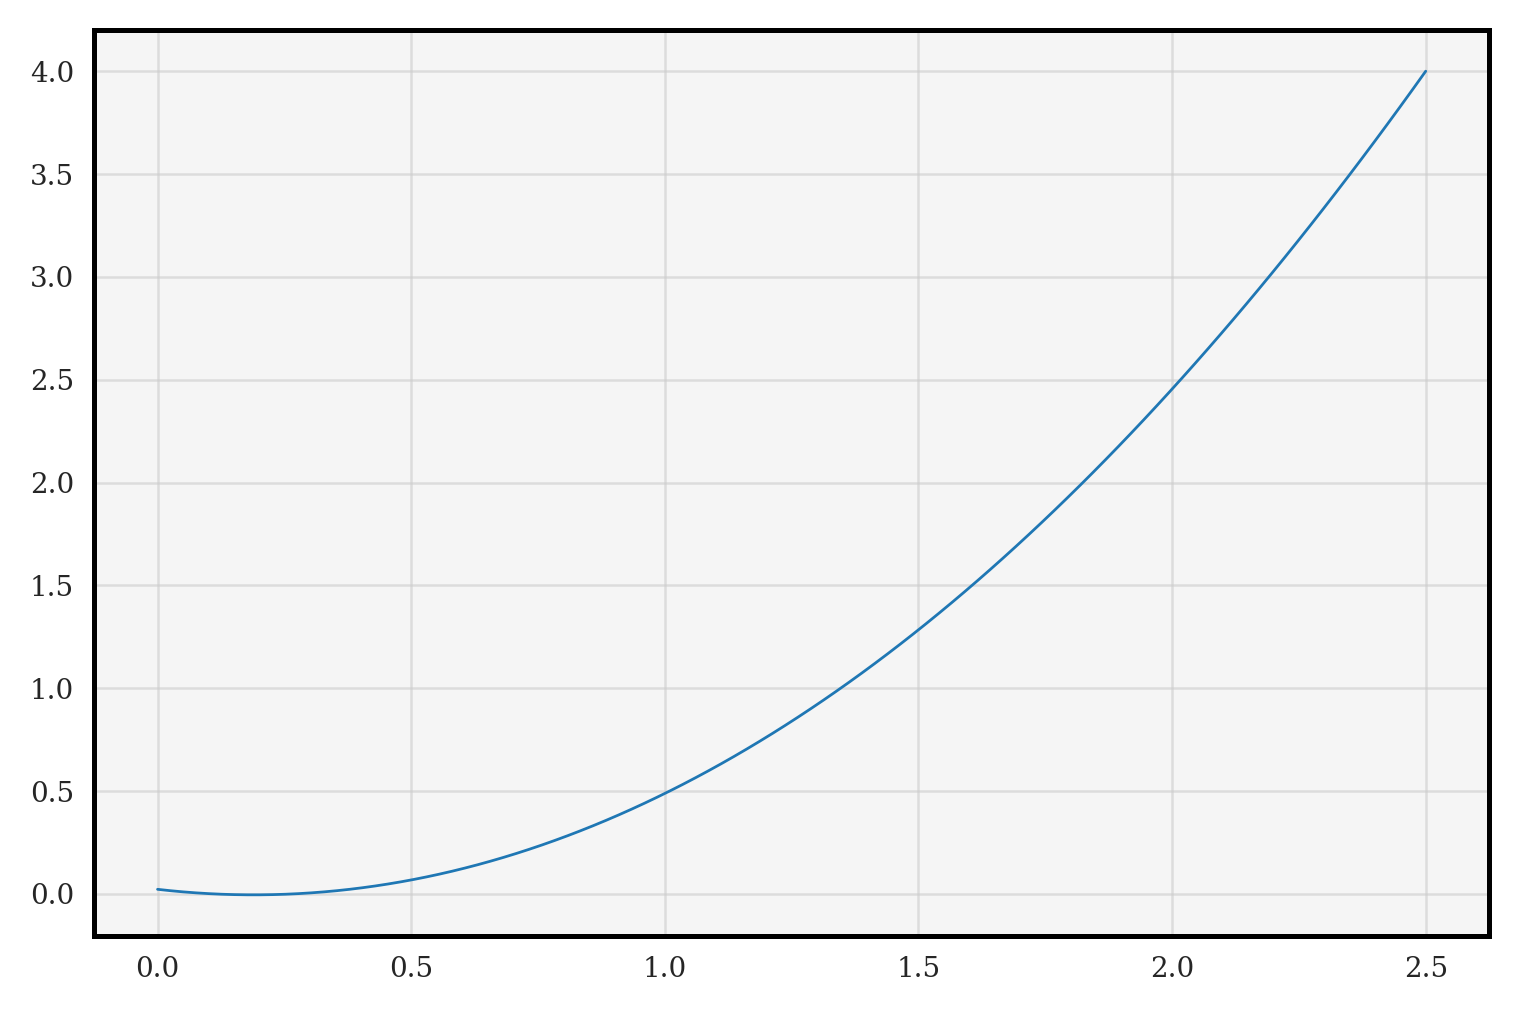

In [59]:
def f(x,a):
    x_0 = 0.05 ; y_0 = 0.01 ; x_1 = 2.5 ; y_1 = 4
    b = (y_1-y_0)/(x_1-x_0) - (x_0+x_1)*a
    c = y_0 - a*x_0**2 - b*x_0
    return a*x**2+b*x+c
X = np.linspace(0,2.5,100)
plt.plot(X,f(X,0.75))

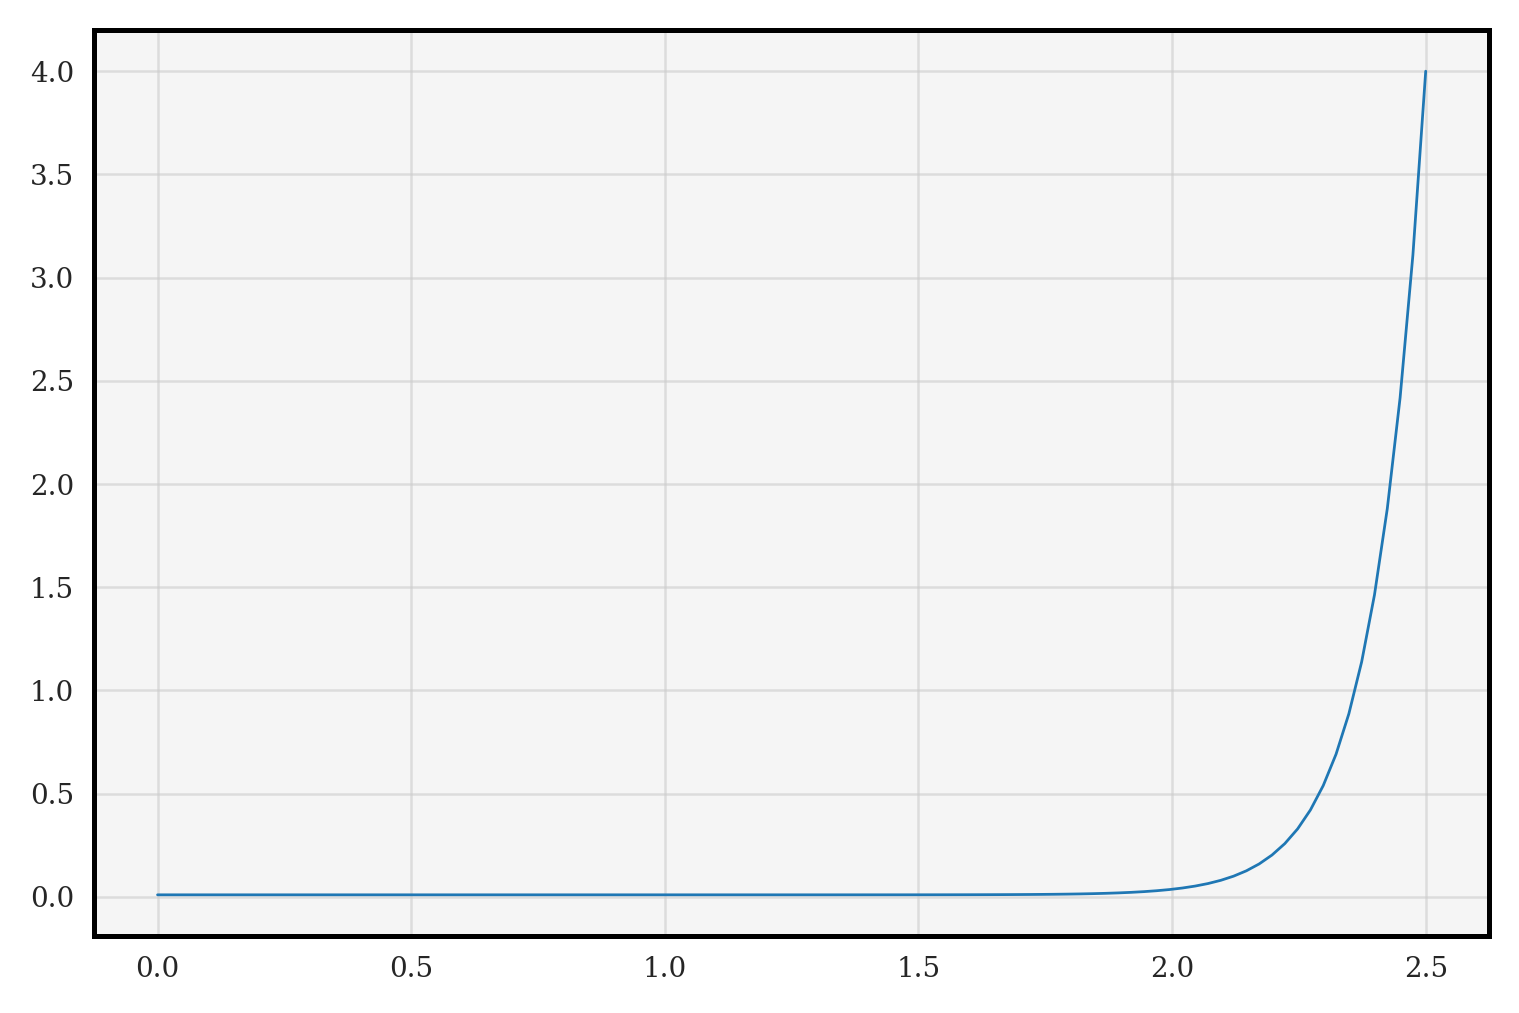

In [108]:
def f(x,d):
    x_0 = 0.05 ; y_0 = 0.01 ; x_1 = 2.5 ; y_1 = 4
    a = (y_0-y_1) / (np.exp(d*x_0)-np.exp(d*x_1))
    c = (y_0+y_1-a*(np.exp(d*x_0)+np.exp(d*x_1)))/2
    return a*np.exp(d*x)+c
X = np.linspace(0,2.5,100)
plt.plot(X,f(X,10)) 

In [73]:
a = np.random.normal(0,1,1000)
np.where(a>0,a,np.max(a)).min()

0.0019816977274890756

In [ ]:
config = TreeConfigParser()
config.readfiles(os.path.join(dir_res, dataset, "config.cfg"))
generator = generators.Generator("segmentation", shift_range=0.2)

NameError: name 'Generator' is not defined

In [27]:
data_gen_losses = model.evaluate(generator.flow([x_test], y_test), batch_size=32)
print(data_gen_losses)

    199/Unknown - 19s 92ms/step - loss: 0.1325


KeyboardInterrupt



In [28]:
t = np.random.randint(200)
dir_It = generator.flow([x_test[t:t+1]], y_test[t:t+1])

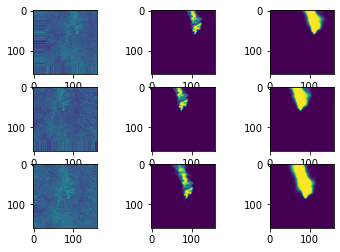

In [38]:
fig, axs = plt.subplots(3, 3)   
for i in range(0,3):
    x,y = generator.next()
    image = x[0]
    label = y[0]
    pred = model.predict(tf.convert_to_tensor(x, np.float32))[0,:,:,0]
    axs[i,0].imshow(image[:,:,0])
    axs[i,1].imshow(label[:,:,0])
    axs[i,2].imshow(pred)
    plt.savefig(f"image{i}.png")

In [40]:
import matplotlib_functions

<Figure size 432x288 with 0 Axes>

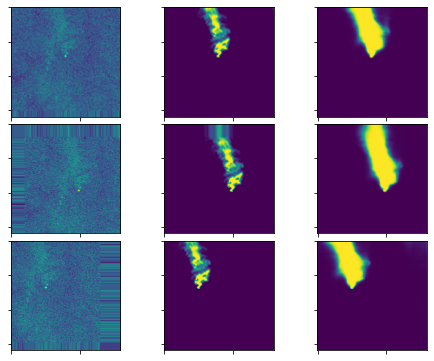

In [51]:
plt.viridis()
axs = matplotlib_functions.set_figure_axs(3, 3, wratio=0.35, hratio=0.75, pad_w_ext_left=0.1, pad_w_ext_right=0.1, pad_w_int=0.1, pad_h_ext=0.1, pad_h_int=0.1)
for i in range(0,3):
    x,y = generator.next()
    image = x[0]
    label = y[0]
    pred = model.predict(tf.convert_to_tensor(x, np.float32))[0,:,:,0]
    axs[3*i+0].imshow(image[:,:,0])
    axs[3*i+1].imshow(label[:,:,0])
    axs[3*i+2].imshow(pred)
for i in range(9):
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
plt.savefig(f"image.png")

In [77]:
ds_test = ds

In [258]:
ds.time

<xarray.DataArray 'time' (idx_img: 3900)>
array(['2015-01-01T14:00:00.000000000', '2015-01-01T22:00:00.000000000',
       '2015-01-01T23:00:00.000000000', ..., '2015-12-23T18:00:00.000000000',
       '2015-12-24T19:00:00.000000000', '2015-12-24T20:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * idx_img  (idx_img) int32 0 1 2 3 4 5 6 ... 3894 3895 3896 3897 3898 3899

### Random output

In [38]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [110]:
idx = int(np.random.uniform(0,data.y.test.shape[0]))
print(model.compute_loss(y=y_test[idx:idx+1], y_pred=pred_test[idx:idx+1]).numpy())

0.48150718


In [187]:
np.unique(ds.point_source.values)

array(['lsce_pPGI_nBBO', 'lsce_pPG_nBBO', 'smart_pBer_nBBer',
       'smart_pBox_nBBox', 'smart_pJan_nBJan', 'smart_pLip_nBLip'],
      dtype=object)

In [141]:
def f(x,a):
    x_0 = 0.05 ; y_0 = 0.01 ; x_1 = np.quantile(x,q=0.99) ; y_1 = 4
    b = (y_1-y_0)/(x_1-x_0) - (x_0+x_1)*a
    c = y_0 - a*x_0**2 - b*x_0
    return a*x**2+b*x+c
X = np.linspace(0,2.5,100)

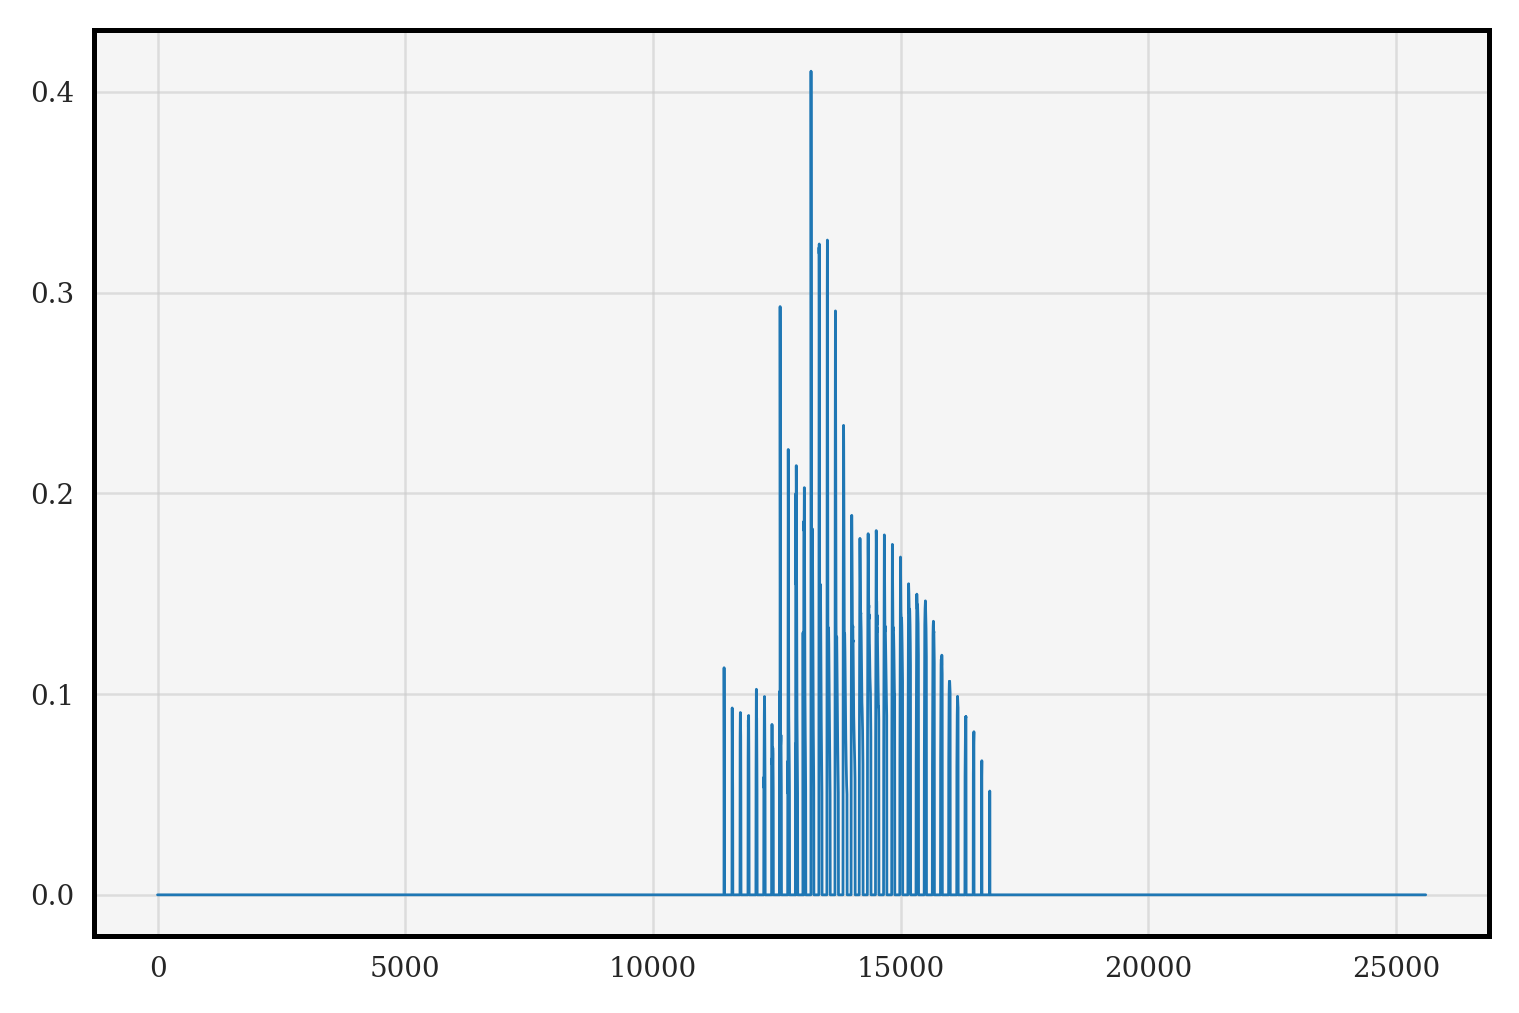

In [142]:
plt.plot(ds_test.plume[idx:idx+1].values.flatten())

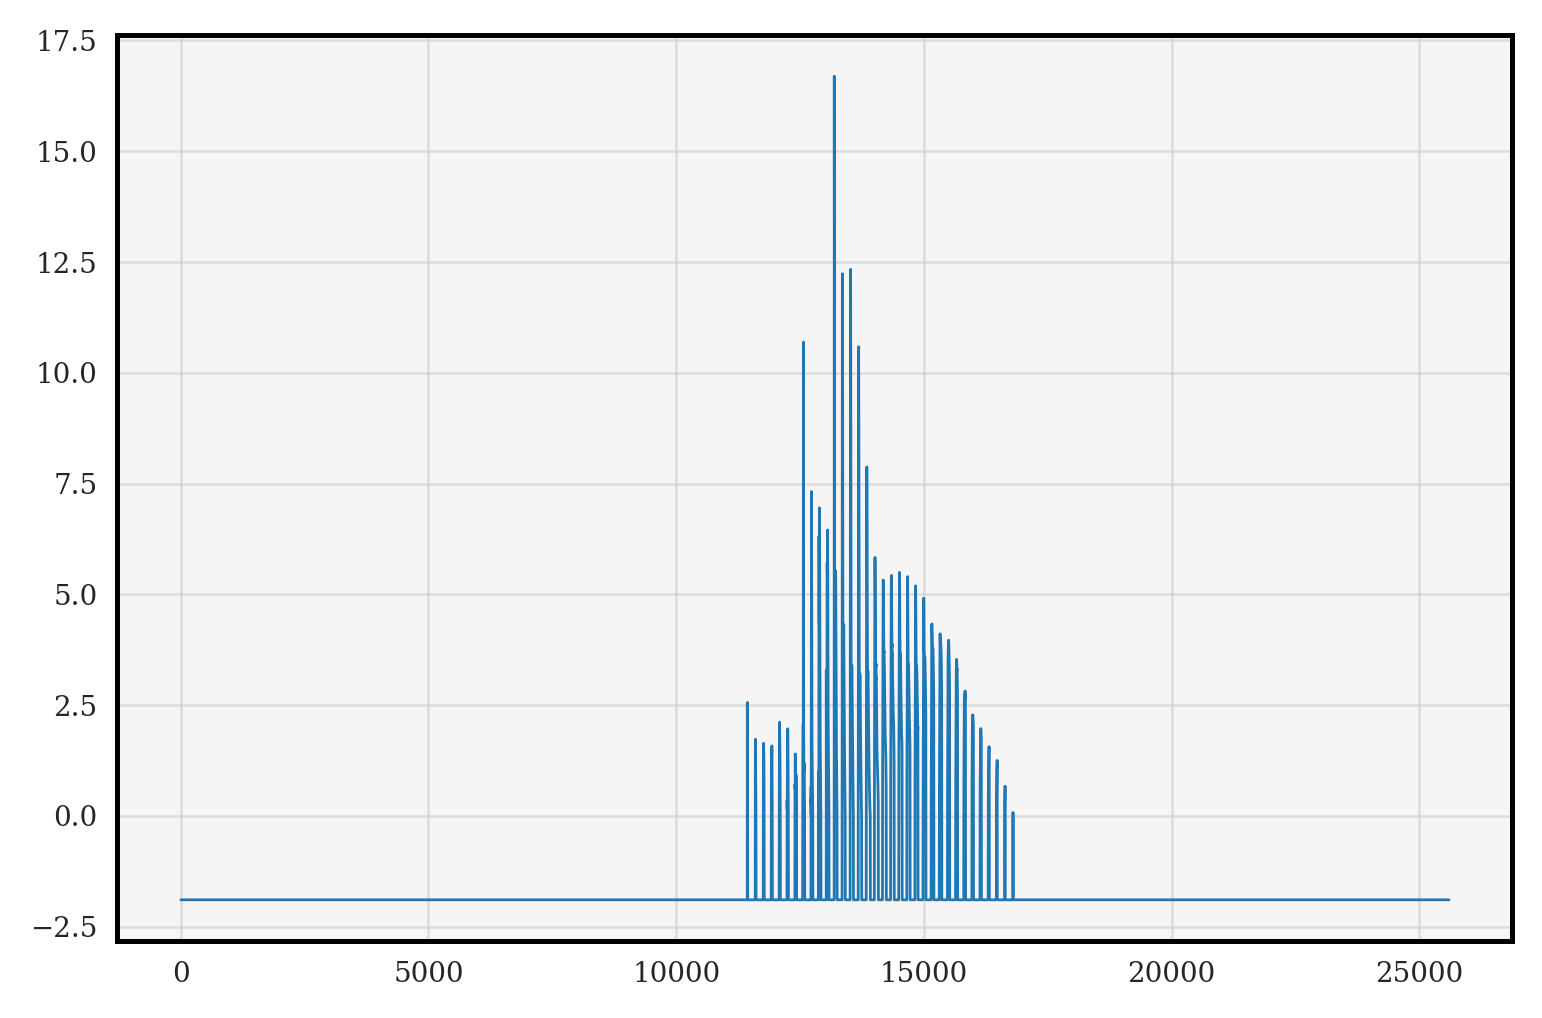

In [144]:
plt.plot(f(ds_test.plume[idx:idx+1].values.flatten(),20))

In [128]:
def calculate_weighted_plume(plume: np.ndarray, min_w: np.float64, max_w: np.float64, curve: str = "linear", param_curve: np.float64 = 1):
    """Calculate a weighted plume given min_w, max_w, and a curve between the two."""
    
    N_data = plume.shape[0]    
    y_min = np.repeat([np.where(plume>0,plume,np.max(plume)).min()], N_data).reshape(N_data, 1, 1)
    y_max = np.quantile(plume, q=0.999, axis=(1, 2)).reshape(N_data, 1, 1)
    weight_min = np.repeat([min_w], N_data).reshape(N_data, 1, 1)
    weight_max = np.repeat([max_w], N_data).reshape(N_data, 1, 1)
    
    if curve == "linear":
        pente = (weight_max - weight_min) / (y_max - y_min)
        b = weight_min - pente * y_min
        y_data = pente * plume + b * np.where(plume > 0, 1, 0)
     
    elif curve == "exponential":
        A_0 = (weight_min-weight_max) / (np.exp(param_curve*y_min)-np.exp(param_curve*y_max))
        b = (weight_min+weight_max-A_0*(np.exp(param_curve*y_min)+np.exp(param_curve*y_max)))/2
        y_data = A_0*np.exp(param_curve*plume)+b*np.where(plume > 0, 1, 0)
        y_data = np.where(plume>0, y_data, 0)
    
    y_data = np.where(y_data < max_w, y_data, max_w)    
    y_data = np.expand_dims(y_data, axis=-1)
    
    return y_data

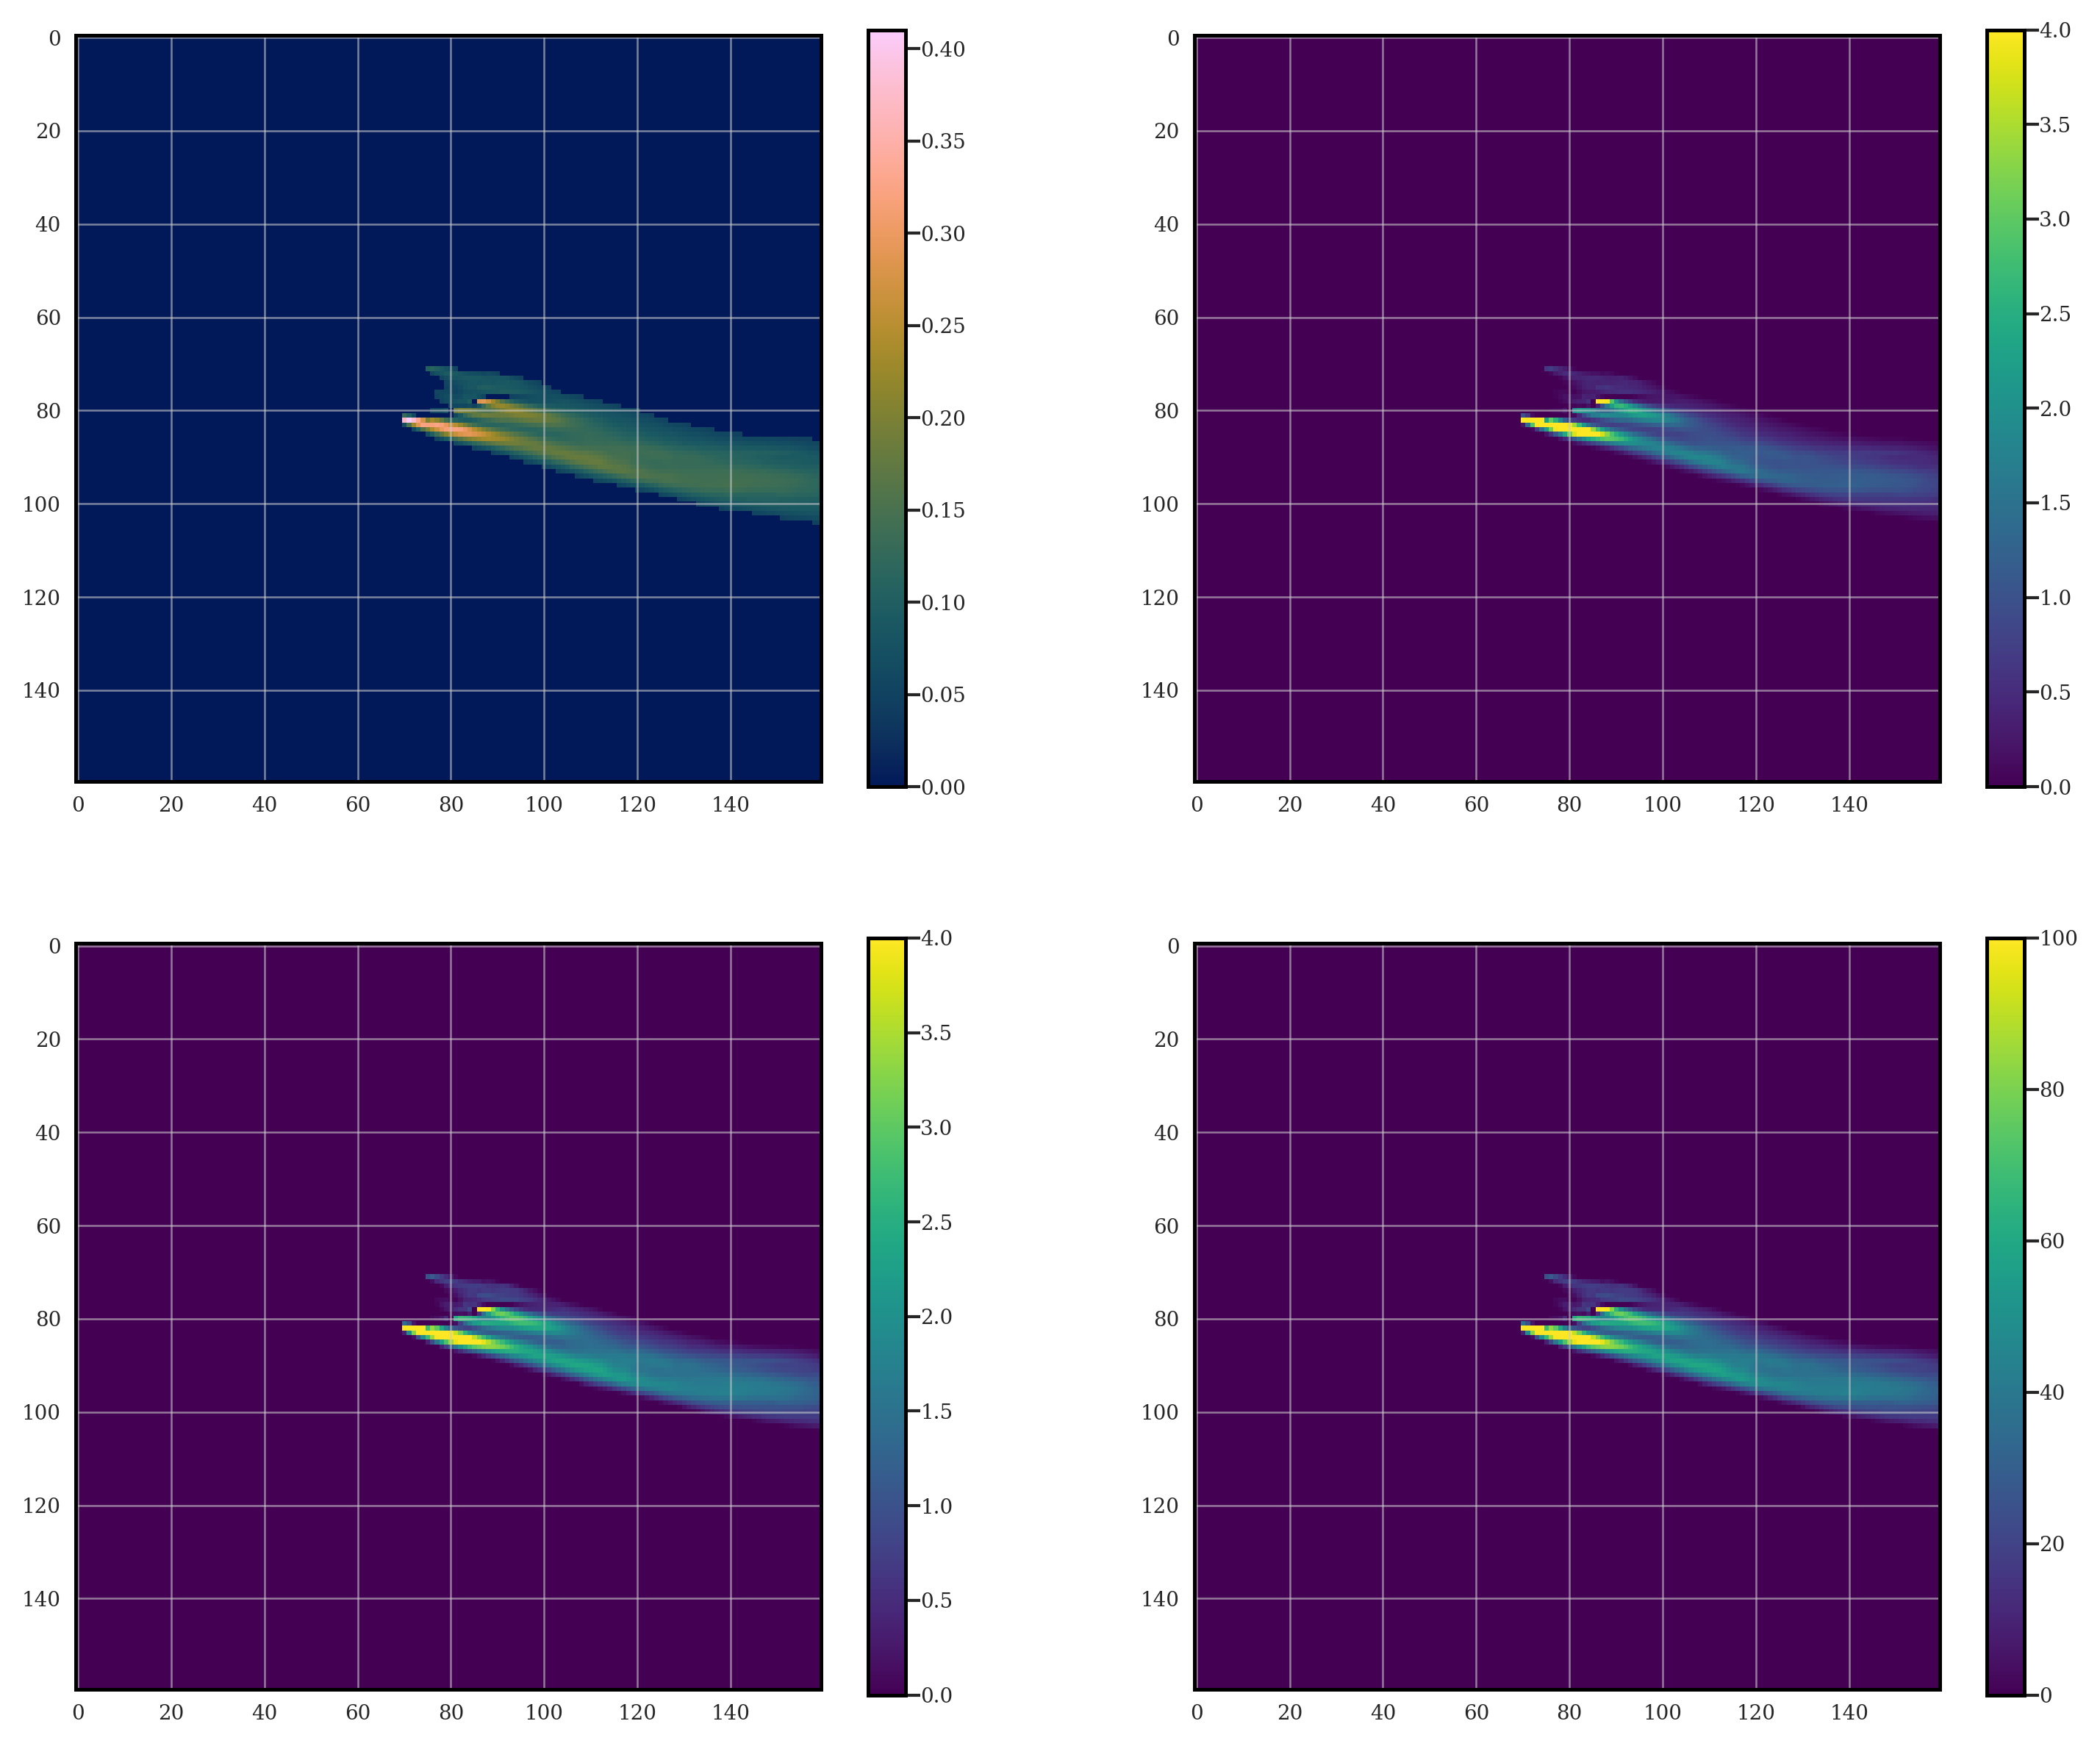

In [129]:
plt.figure(figsize=(12,10))
idx = int(np.random.uniform(ds_test.N_img))
parabolic_test = calculate_weighted_plume(ds_test.plume[idx:idx+1].values, 0.01, 4, "exponential", param_curve=5)
linear_test = calculate_weighted_plume(ds_test.plume[idx:idx+1].values, 0.01, 4, "linear")
linear_2 = calculate_weighted_plume(ds_test.plume[idx:idx+1].values, 0.01, 100, "linear")
plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(data.y.plume_test[idx]), cmap = cm.batlow)
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(parabolic_test[0,:,:,0])
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(linear_test[0,:,:,0])
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(linear_2[0,:,:,0])
plt.colorbar()

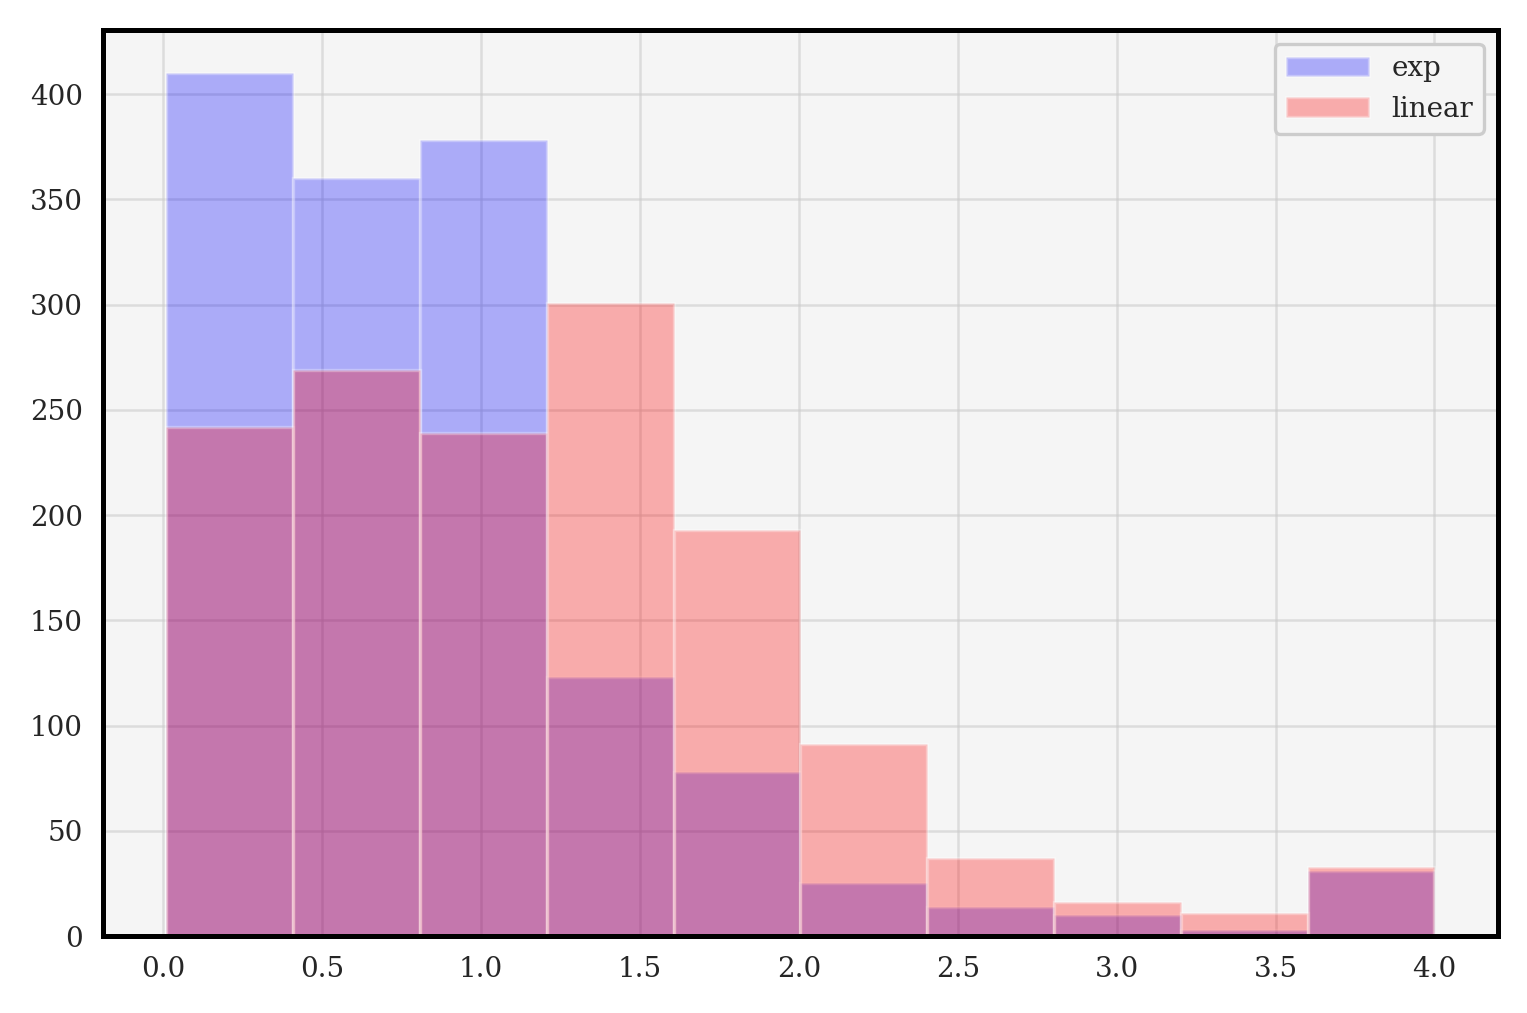

In [130]:
plt.hist(np.squeeze(parabolic_test[linear_test>0]).flatten(), color="blue", label="exp", alpha=0.3)
plt.hist(np.squeeze(linear_test[linear_test>0]).flatten(), color="red", label="linear", alpha=0.3)
plt.legend()

pw loss 0.45842478
pw2 loss 0.48271877
pw3 loss 0.46553066
pw6 loss 0.44752526
idx: 3169
origin: smart_pBer_nBBer
time: 2015-02-17T11:00:00.000000000
emiss: [28.58006 29.38831 31.82424 34.47468 34.73873 32.68085]


Text(0.5, 1.0, 'pred')

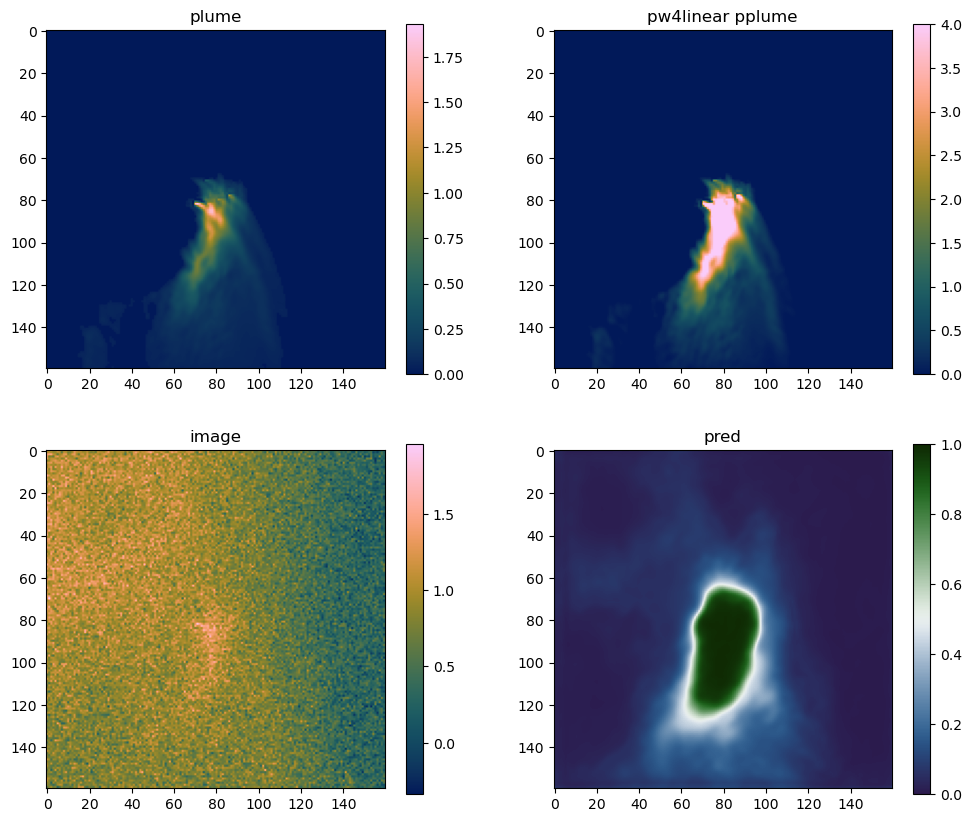

In [533]:
idx = int(np.random.uniform(0,data.y.test.shape[0]))
ds_idx = ds_test.isel(idx_img=idx)
while ds_idx.point_source != "smart_pBer_nBBer":
    idx = int(np.random.uniform(0,data.y.test.shape[0]))
    ds_idx = ds_test.isel(idx_img=idx)
    
print("pw loss", model.compute_loss(y=y_test[idx:idx+1], y_pred=pred_test[idx:idx+1]).numpy()/np.median(all_loss_test))
linear_2 = calculate_weighted_plume(ds_test.plume[idx:idx+1].values, 0.01, 2, "linear")
linear_3 = calculate_weighted_plume(ds_test.plume[idx:idx+1].values, 0.01, 3, "linear")
linear_6 = calculate_weighted_plume(ds_test.plume[idx:idx+1].values, 0.01, 6, "linear")
print("pw2 loss", model.compute_loss(y=tf.convert_to_tensor(linear_2, np.float32),y_pred= pred_test[idx:idx+1]).numpy()/np.median(linear_2_loss))
print("pw3 loss", model.compute_loss(y=tf.convert_to_tensor(linear_3, np.float32),y_pred= pred_test[idx:idx+1]).numpy()/np.median(linear_3_loss))
print("pw6 loss", model.compute_loss(y=tf.convert_to_tensor(linear_6, np.float32),y_pred= pred_test[idx:idx+1]).numpy()/np.median(linear_6_loss))
print("idx:", idx)
print("origin:", ds_idx.point_source.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)

plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(data.y.plume_test[idx]), cmap = cm.batlow)
plt.colorbar()
plt.title("plume")

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(data.y.test[idx]), cmap = cm.batlow)
#plt.imshow(np.squeeze(parabolic_test[idx]), cmap=cm.batlow)
plt.colorbar()
plt.title("pw4linear pplume")

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(data.x.test[idx]), cmap=cm.batlow)
plt.colorbar()
plt.title("image")

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.test[idx], 0))[0]), cmap=cm.cork, vmin=0, vmax=1)
plt.colorbar()
plt.title("pred")

### Individual losses

In [487]:
all_loss_test = pixel_weighted_cross_entropy(y_test, pred_test, reduction=False)
all_loss_test = np.mean(all_loss_test,axis=(1,2))
linear_2 = calculate_weighted_plume(ds_test.plume.values, 0.01, 2, "linear")
linear_3 = calculate_weighted_plume(ds_test.plume.values, 0.01, 3, "linear")
linear_6 = calculate_weighted_plume(ds_test.plume.values, 0.01, 6, "linear")
linear_2_loss = pixel_weighted_cross_entropy(tf.convert_to_tensor(linear_2, np.float32), pred_test,reduction=False).numpy()
linear_2_loss = np.mean(linear_2_loss, axis=(1,2))
linear_3_loss = pixel_weighted_cross_entropy(tf.convert_to_tensor(linear_3, np.float32), pred_test,reduction=False).numpy()
linear_3_loss = np.mean(linear_3_loss, axis=(1,2))
linear_6_loss = pixel_weighted_cross_entropy(tf.convert_to_tensor(linear_6, np.float32), pred_test,reduction=False).numpy()
linear_6_loss = np.mean(linear_6_loss, axis=(1,2))


In [51]:
n_outliers_val = int(0.01*len(all_loss_test))
indices_with_no_outliers = np.argpartition(all_loss_test, -n_outliers_val)[:-n_outliers_val]
indices_outliers = np.argpartition(all_loss_test, -n_outliers_val)[-n_outliers_val:]

In [ ]:
x_train = tf.convert_to_tensor(data.x.train[0:len(all_loss_test)], np.float32)
y_train = tf.convert_to_tensor(data.y.train[0:len(all_loss_test)], np.float32)
pred_train = tf.convert_to_tensor(model.predict(x_train), np.float32)

In [23]:
all_loss_train = pixel_weighted_cross_entropy(y_train, pred_train, reduction=False)
all_loss_train = np.mean(all_loss_train,axis=(1,2))

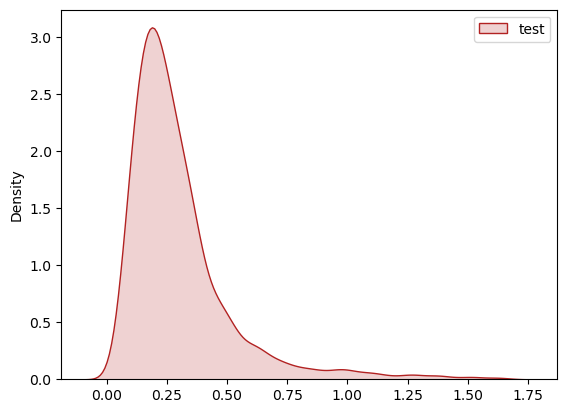

In [54]:
sns.kdeplot(all_loss_test[indices_with_no_outliers], label="test", color="firebrick", fill=True, alpha=0.2)
plt.legend();

In [83]:
np.median(all_loss_test)

0.24419317

### Segmentation losses with respect to characteristics of the image-plume

In [87]:
df = pd.DataFrame({'loss': all_loss_test[indices_with_no_outliers],
                   'origin': ds_test.point_source.values[indices_with_no_outliers].astype(str),
                   'time': ds_test.v_hour.values[indices_with_no_outliers],
                   'emiss': ds_test.emiss.values[indices_with_no_outliers,0]
                  })

In [86]:
df = pd.DataFrame({'loss': all_loss_test,
                   'origin': ds_test.folder.values.astype(str),
                   'time': ds_test.v_hour.values,
                   'emiss': ds_test.emiss.values[:,0]
                  })

AttributeError: 'Dataset' object has no attribute 'folder'

In [365]:
df_outliers = pd.DataFrame({'loss': all_loss_test[indices_outliers],
                   'origin': ds_test.folder.values[indices_outliers].astype(str),
                   'time': ds_test.v_hour.values[indices_outliers],
                   'emiss': ds_test.emiss.values[indices_outliers,0]
                  })

In [88]:
sns.kdeplot(
    data=df_outliers,
    x="loss",
    hue="origin",
    common_norm=True,
    fill=True
)

NameError: name 'df_outliers' is not defined

In [332]:
df["emiss"] = pd.qcut(df["emiss"], q=4, precision=2)

In [89]:
df["origin"] = np.where(df["origin"].values == "smart_pBox_nBBox", "Boxberg (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "smart_pLip_nBLip", "Lippendorf (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "smart_pJan_nBJan", "Janschwälde (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "lsce_pPG_nBBO", "Grand Paris", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "lsce_pPGI_nBBO", "Grand Paris + IDF", df["origin"].values)


[None, None]

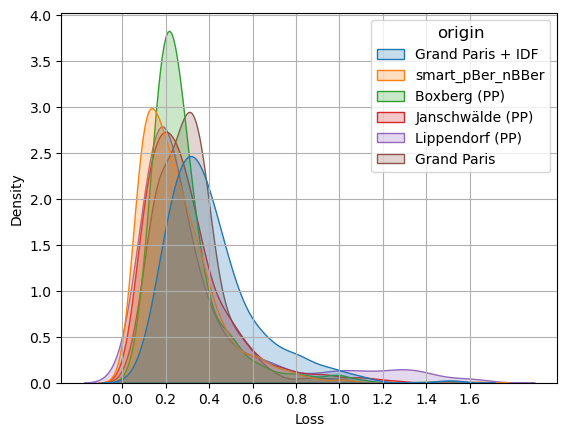

In [93]:
ax = sns.kdeplot(
    data=df,
    x="loss",
    hue="origin",
    common_norm=False,
    fill=True
)
plt.xlabel("Loss", size=10)
plt.ylabel("Density", size=10)
plt.xticks(size=10)
plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
plt.yticks(size=10)
plt.grid()
plt.setp(ax.get_legend().get_texts(), fontsize='10')
plt.setp(ax.get_legend().get_title(), fontsize='12')

In [272]:
for origin in np.unique(df["origin"]):
    print(origin, "mean", df[df["origin"]==origin].loss.mean())
    print(origin, "mediane", df[df["origin"]==origin].loss.median())
    print(origin, "var", df[df["origin"]==origin].loss.var())

Boxberg (PP) mean 0.28706792
Boxberg (PP) mediane 0.24066457
Boxberg (PP) var 0.031202914
Grand Paris mean 0.3032034
Grand Paris mediane 0.29536048
Grand Paris var 0.021607649
Grand Paris + IDF mean 0.40739453
Grand Paris + IDF mediane 0.35690704
Grand Paris + IDF var 0.042950958
Janschwälde (PP) mean 0.29950306
Janschwälde (PP) mediane 0.25431445
Janschwälde (PP) var 0.04166856
Lippendorf (PP) mean 0.33950484
Lippendorf (PP) mediane 0.21549764
Lippendorf (PP) var 0.099614434
smart_pBer_nBBer mean 0.25532544
smart_pBer_nBBer mediane 0.21106893
smart_pBer_nBBer var 0.03198291


### Very bad evaluations

In [ ]:
n_max_val = int(0.01*len(all_loss_test))
worst_eval_indices = np.argpartition(all_loss_test, -n_max_val)[-n_max_val:]

In [ ]:
idx_worst = np.random.choice(worst_eval_indices)
print(model.compute_loss(y=y_test[idx_worst:idx_worst+1], y_pred=pred_test[idx_worst:idx_worst+1]).numpy())

In [56]:
idx_worst = np.random.choice(worst_eval_indices)
print(model.compute_loss(y=y_test[idx_worst:idx_worst+1], y_pred=pred_test[idx_worst:idx_worst+1]).numpy())
ds_idx = ds_valid.isel(idx_img=idx_worst)
print("origin:", ds_idx.folder.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)

plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(data.y.trace_valid[idx_worst]))
plt.colorbar()
plt.title("trace")

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(data.y.valid[idx_worst]))
plt.colorbar()
plt.title("truth")

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(data.x.valid[idx_worst]))
plt.colorbar()
plt.title("image")

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx_worst], 0))[0]))
plt.colorbar()
plt.title("pred")

NameError: name 'worst_eval_indices' is not defined

### Histogram perf.

In [160]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
font = {'size'   : 20}
plt.rc('font', **font)

In [163]:
y_trace = data.y.trace_valid.flatten()
y_weight = data.y.valid.flatten()
y_bin = tf.cast(data.y.valid > 0, data.y.valid.dtype).numpy().flatten()


#pred_test = model.predict(tf.convert_to_tensor(data.x_test[0], np.float32), batch_size=64)
y_pred = pred_test.numpy().flatten()

distance_to_truth = np.abs(y_pred-y_bin)

In [164]:
df = pd.DataFrame({'y_true': y_bin, 'y_pred': y_pred, 'y_trace': y_trace,
                   'dtt': distance_to_truth})

In [165]:
df_pos = df.copy()
df_pos = df_pos[df_pos["y_trace"]>0]
df_pos["y_trace_bin"] = pd.qcut(df_pos["y_trace"], 6, precision=2)

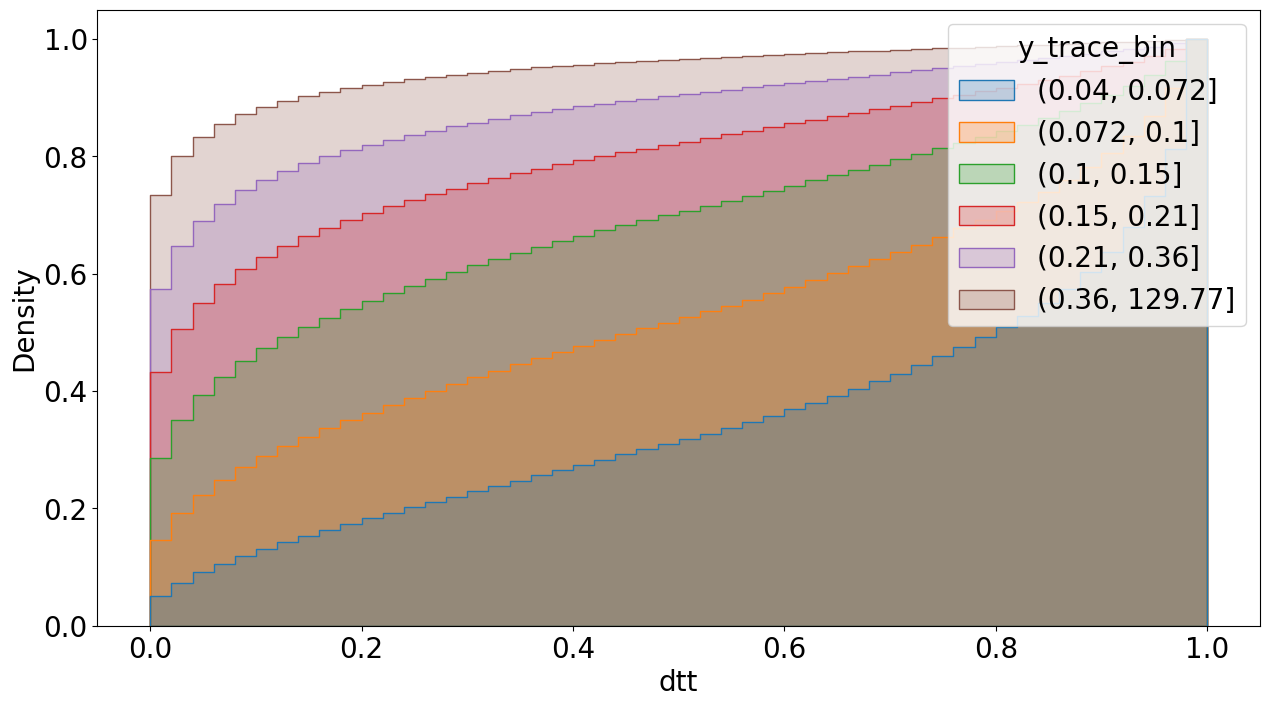

In [167]:
plt.figure(figsize=(15,8))
sns.histplot(
    data=df_pos,
    x="dtt",
    hue="y_trace_bin",
    log_scale=False,
    element="step",
    cumulative=True,
    stat="density",
    common_norm=False,
    bins=50,
)
#plt.savefig(os.path.join("nb/sim/fig",dataset + "_cum_hist_dtt_pos.png"), transparent=True)

In [168]:
df_neg = df.copy()
df_neg = df_neg[df_neg["y_trace"]==0]

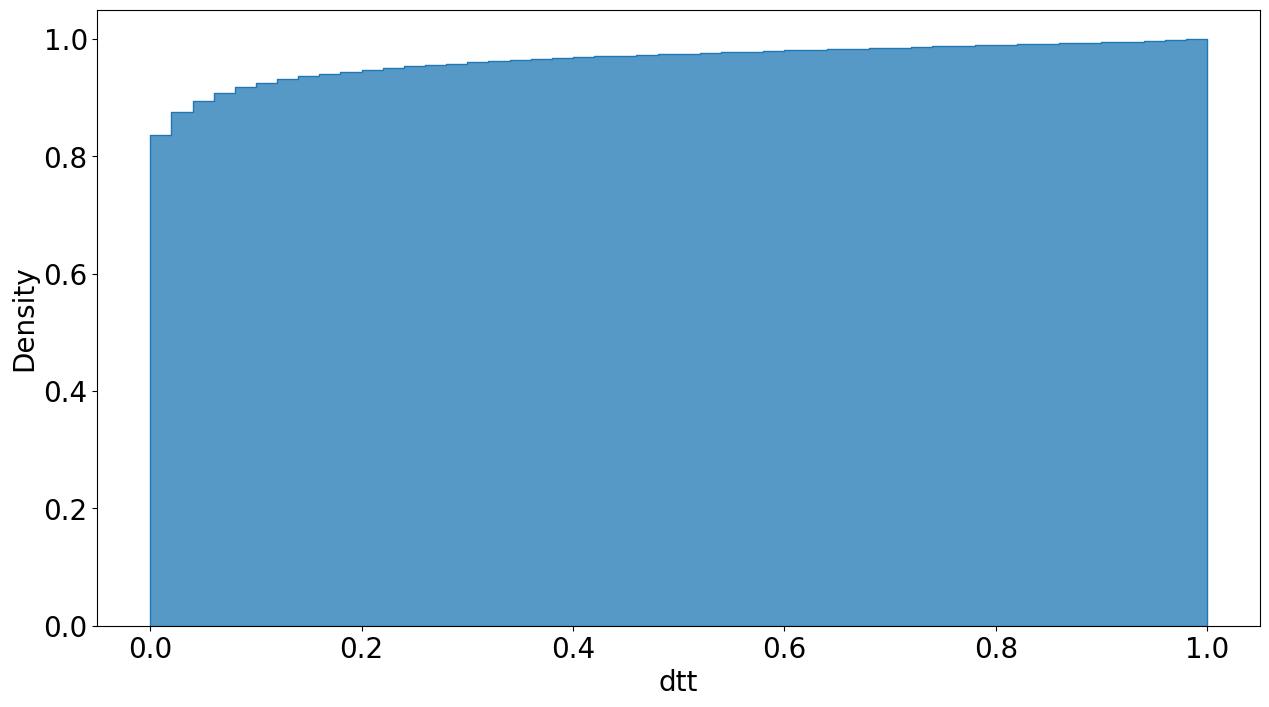

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(
    data=df_neg,
    x="dtt",
    log_scale=False,
    element="step",
    cumulative=True,
    stat="density",
    common_norm=False,
    bins=50,
)

### Save individual plots

In [330]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [95]:
config_weights = TreeConfigParser()
config_weights.readfiles(os.path.join(dir_res, weights, "config.cfg"))
weights_ds = config_weights.get("data.directory.name")
dir_fig = os.path.join("eval/fig/seg", weights_ds)
if not os.path.exists(dir_fig):
    os.makedirs(dir_fig)

In [96]:
idx = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))

0.10605723


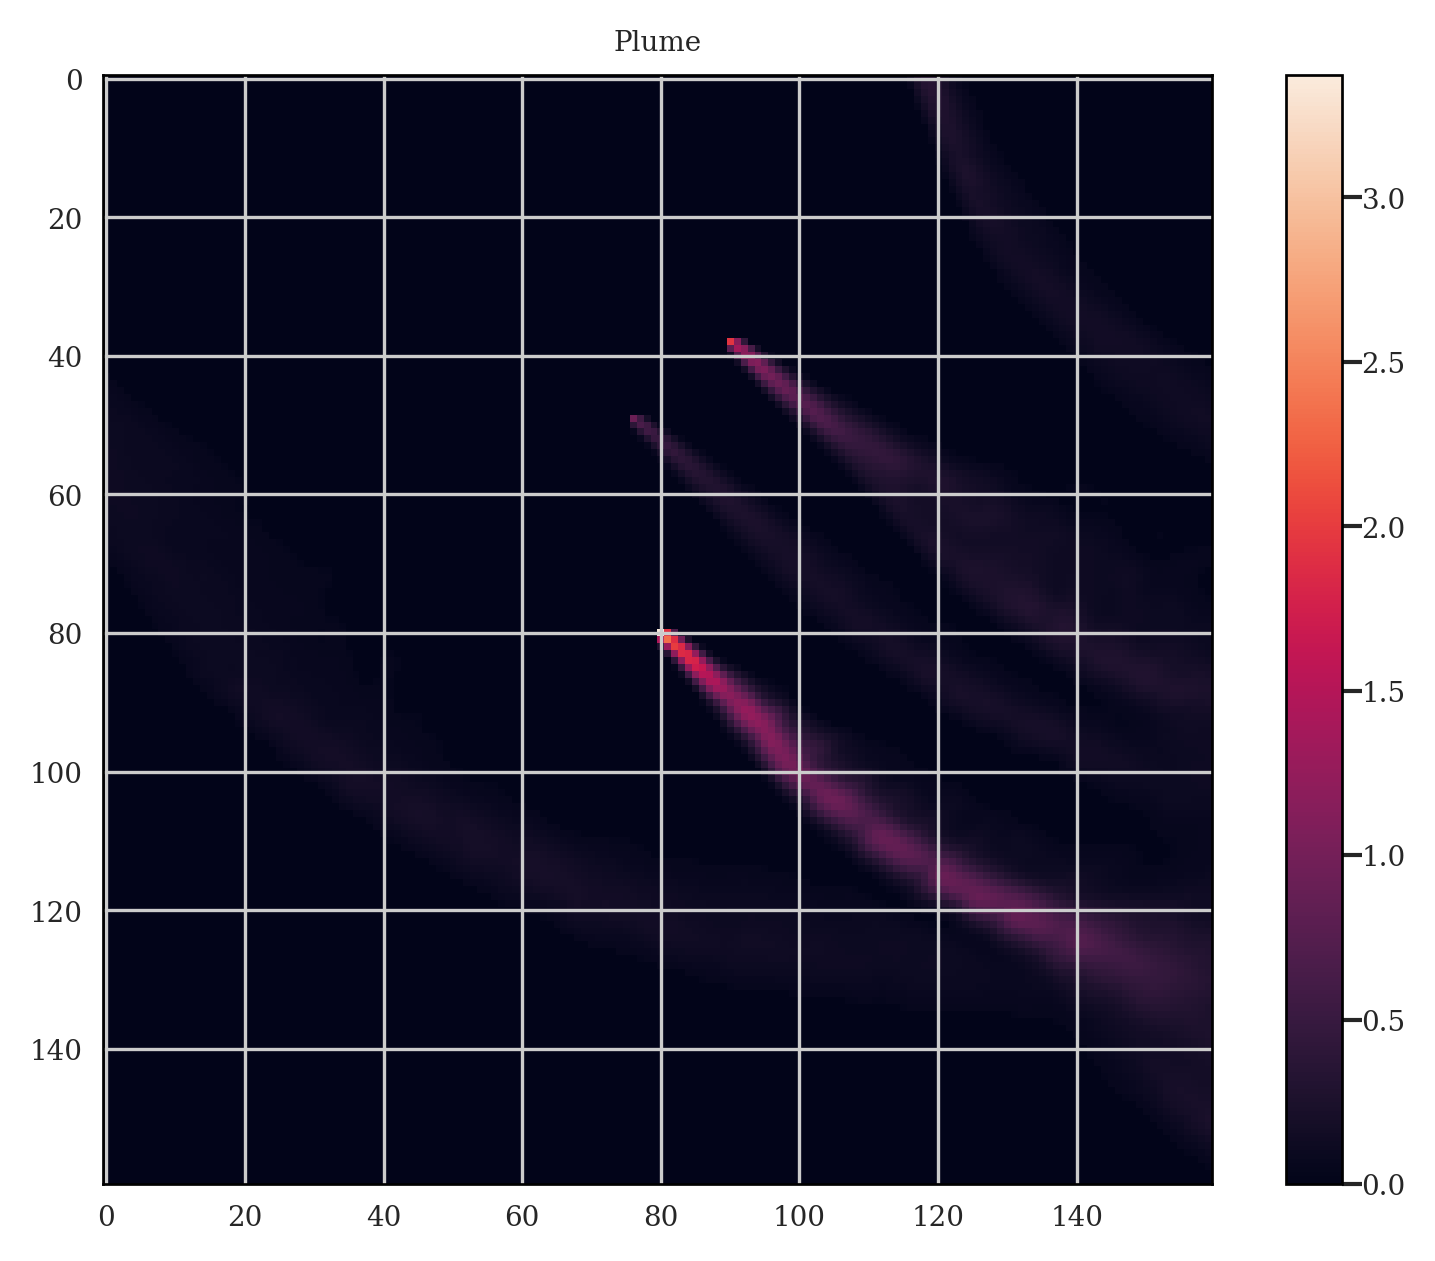

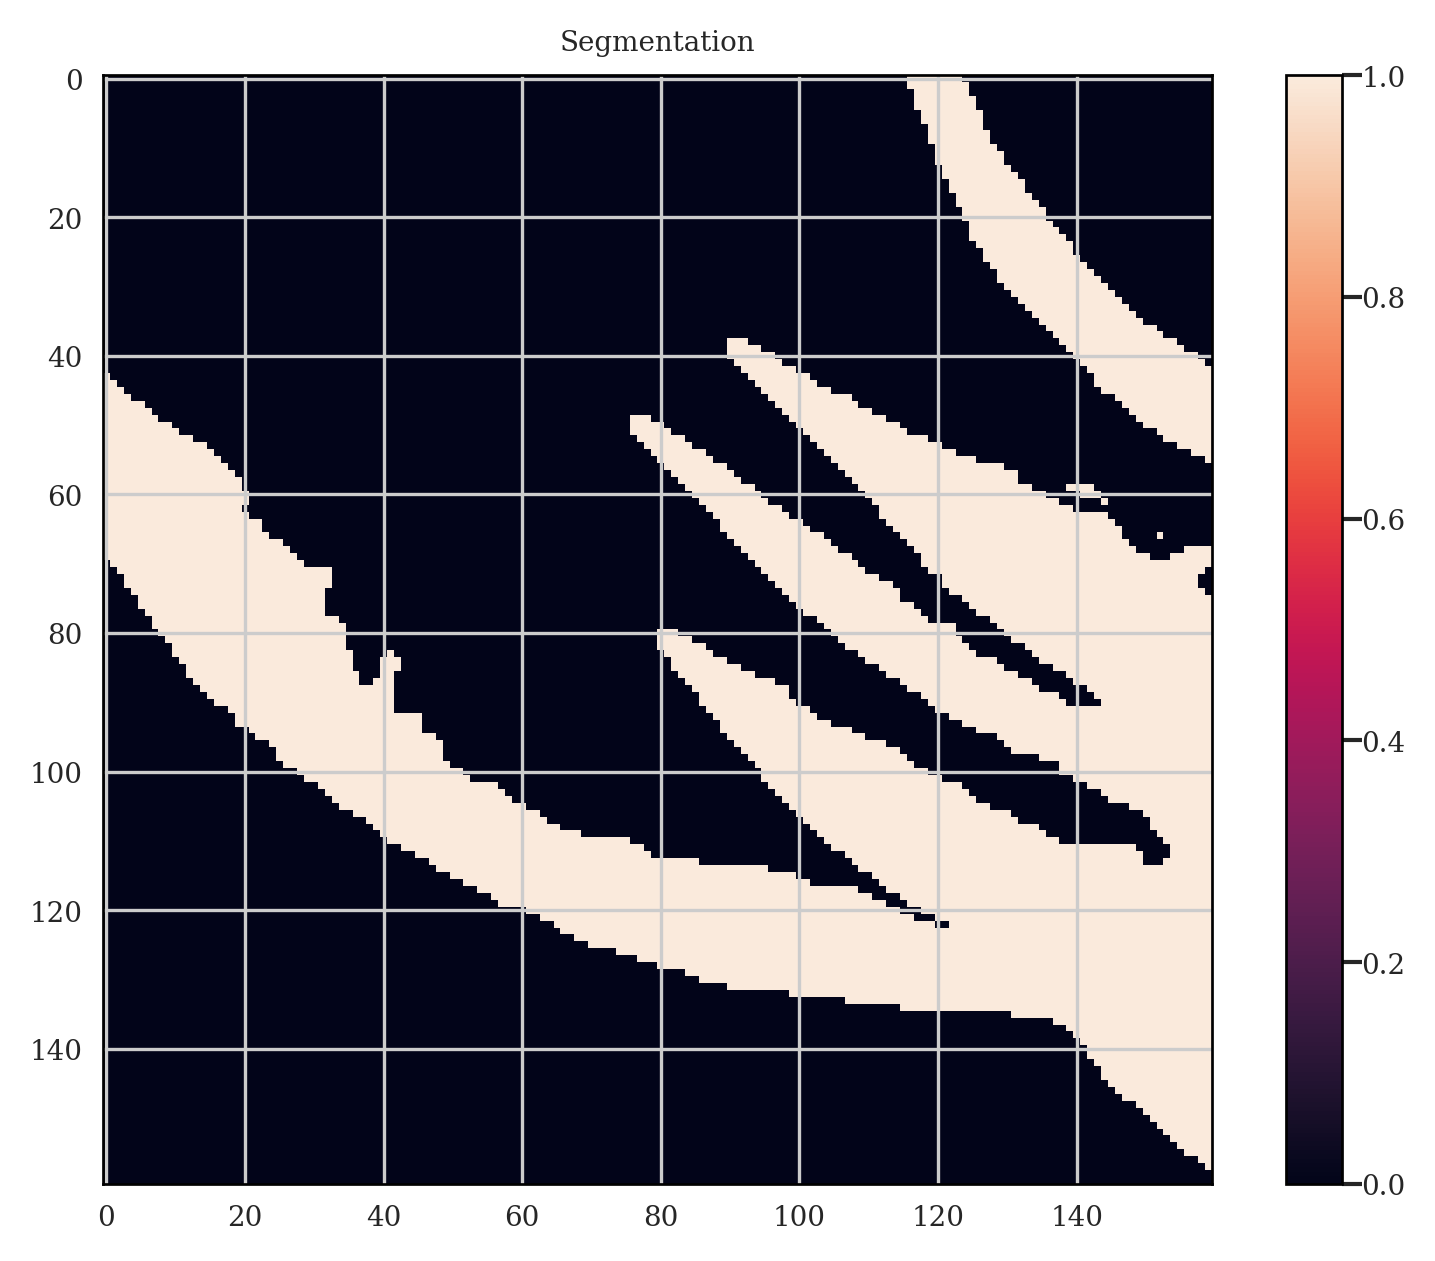

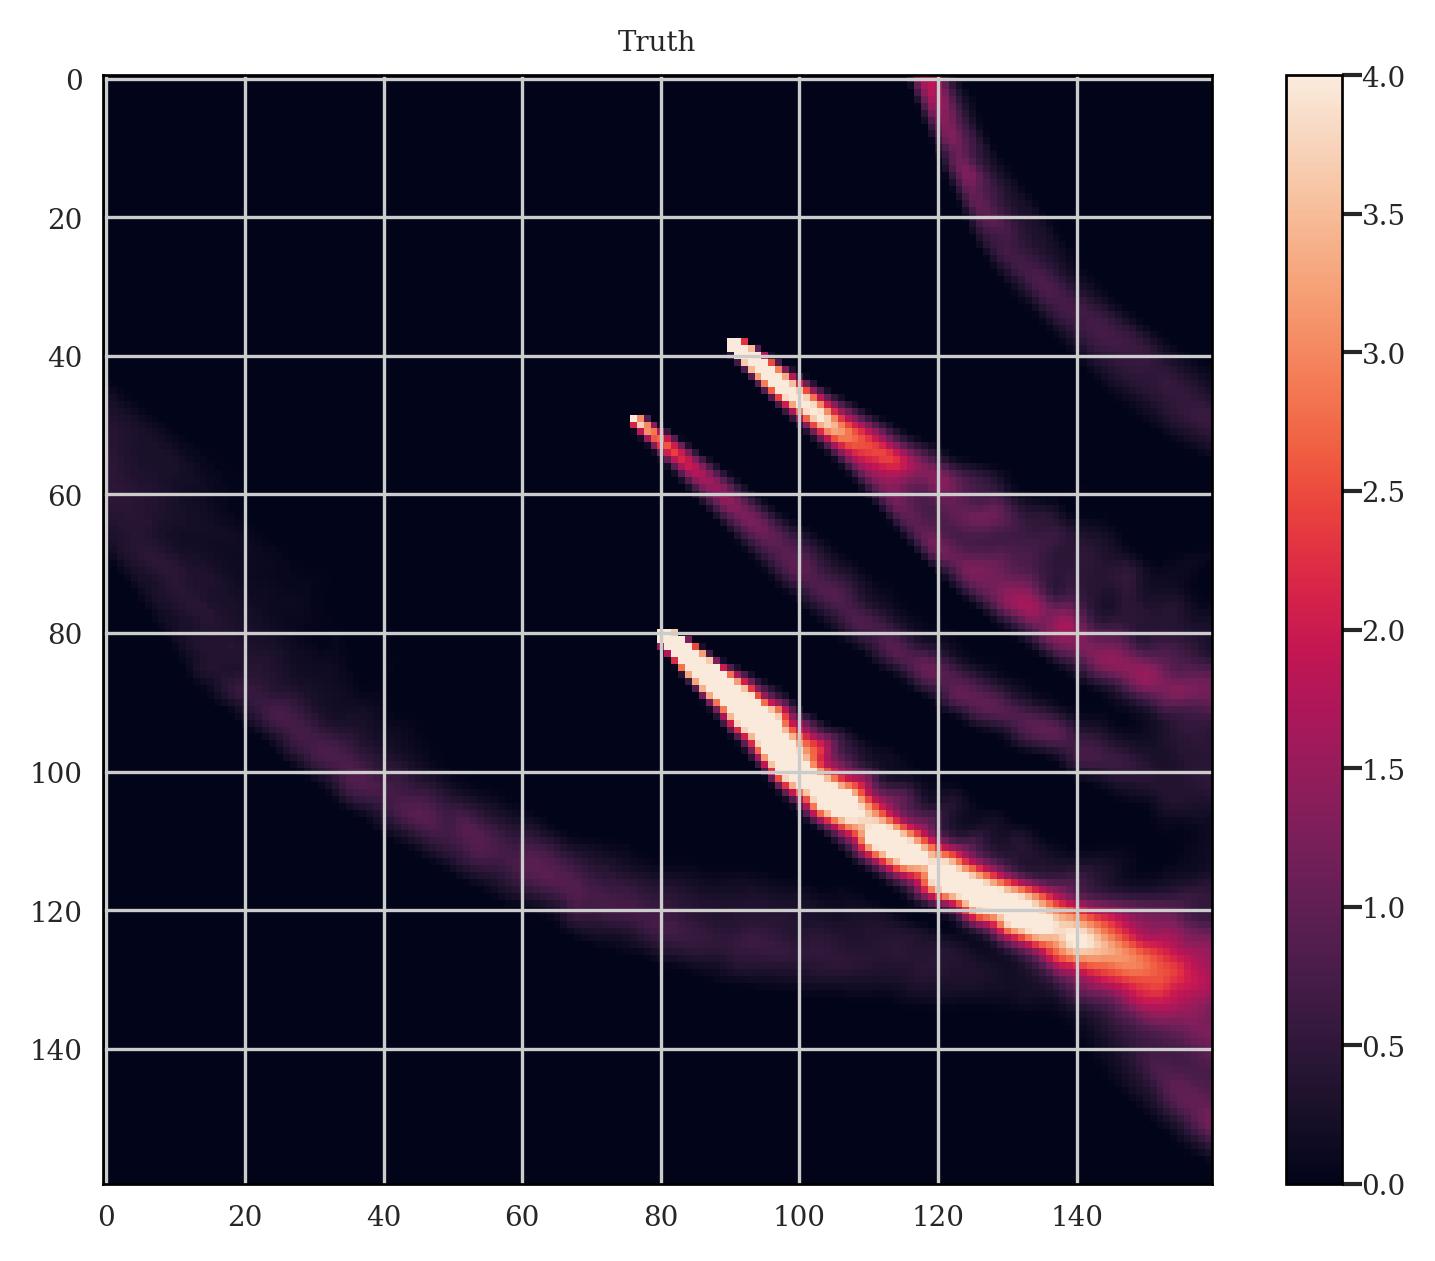

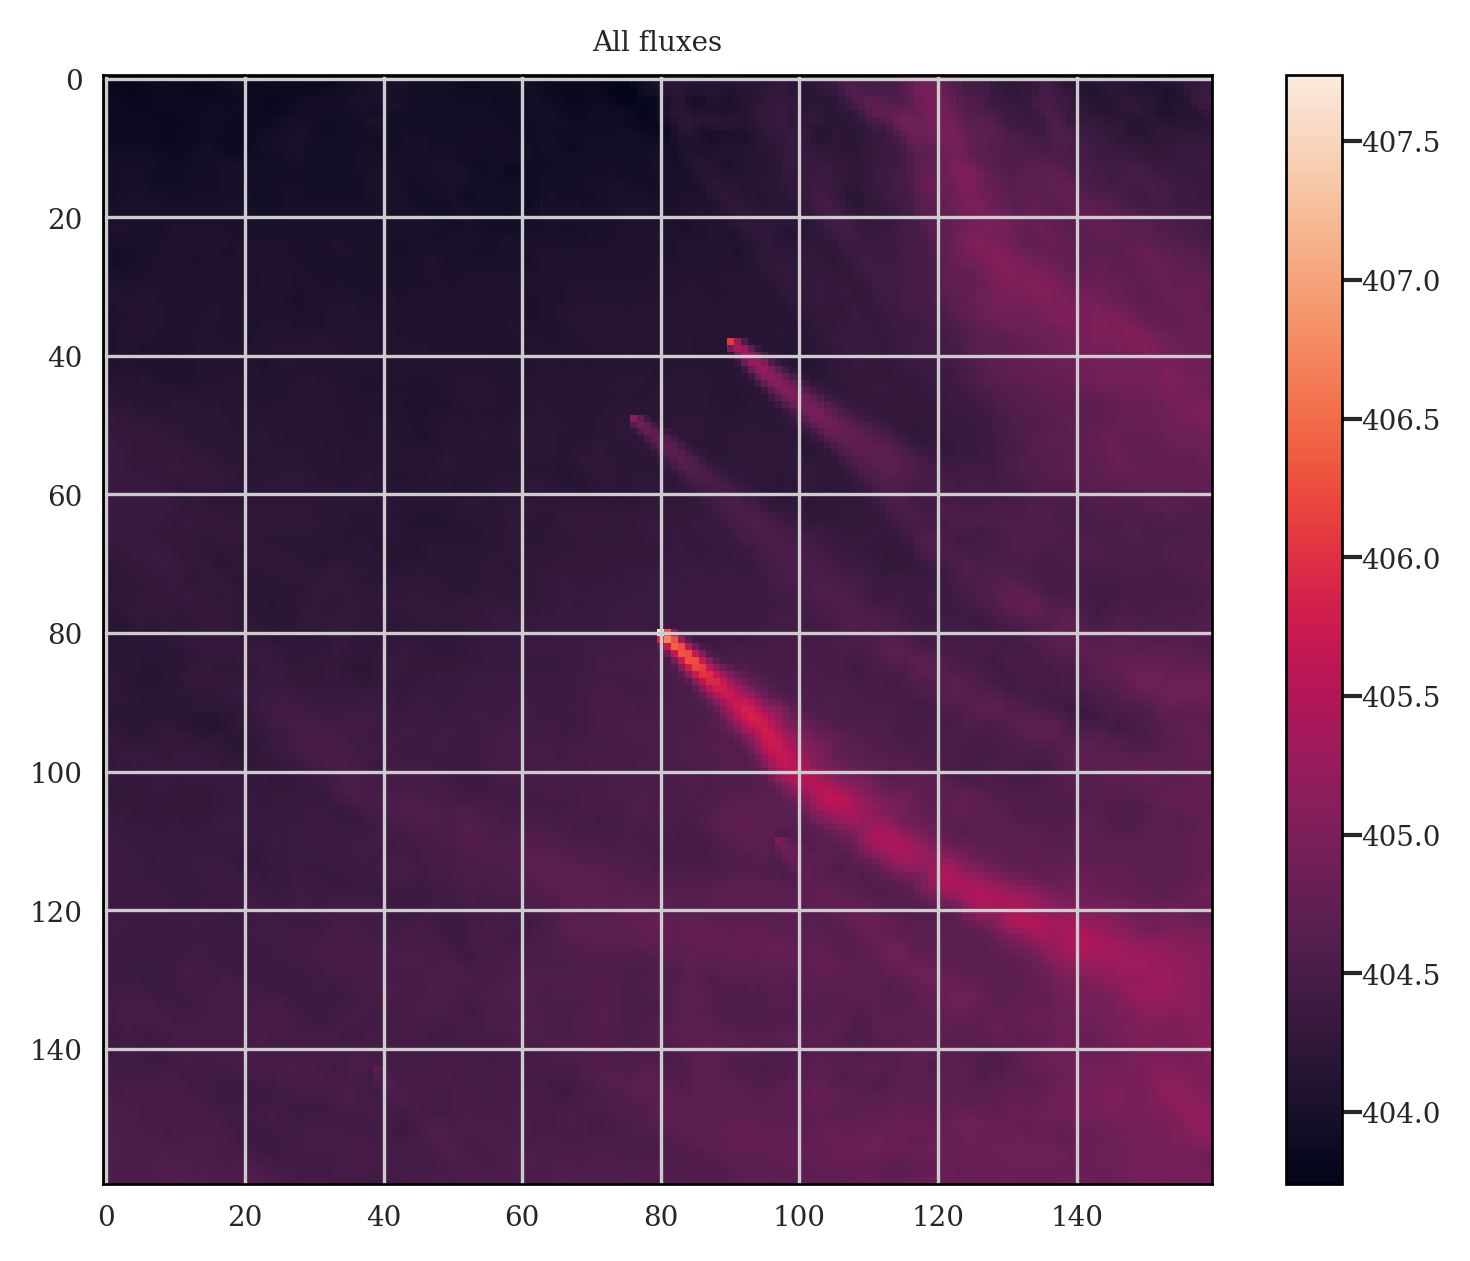

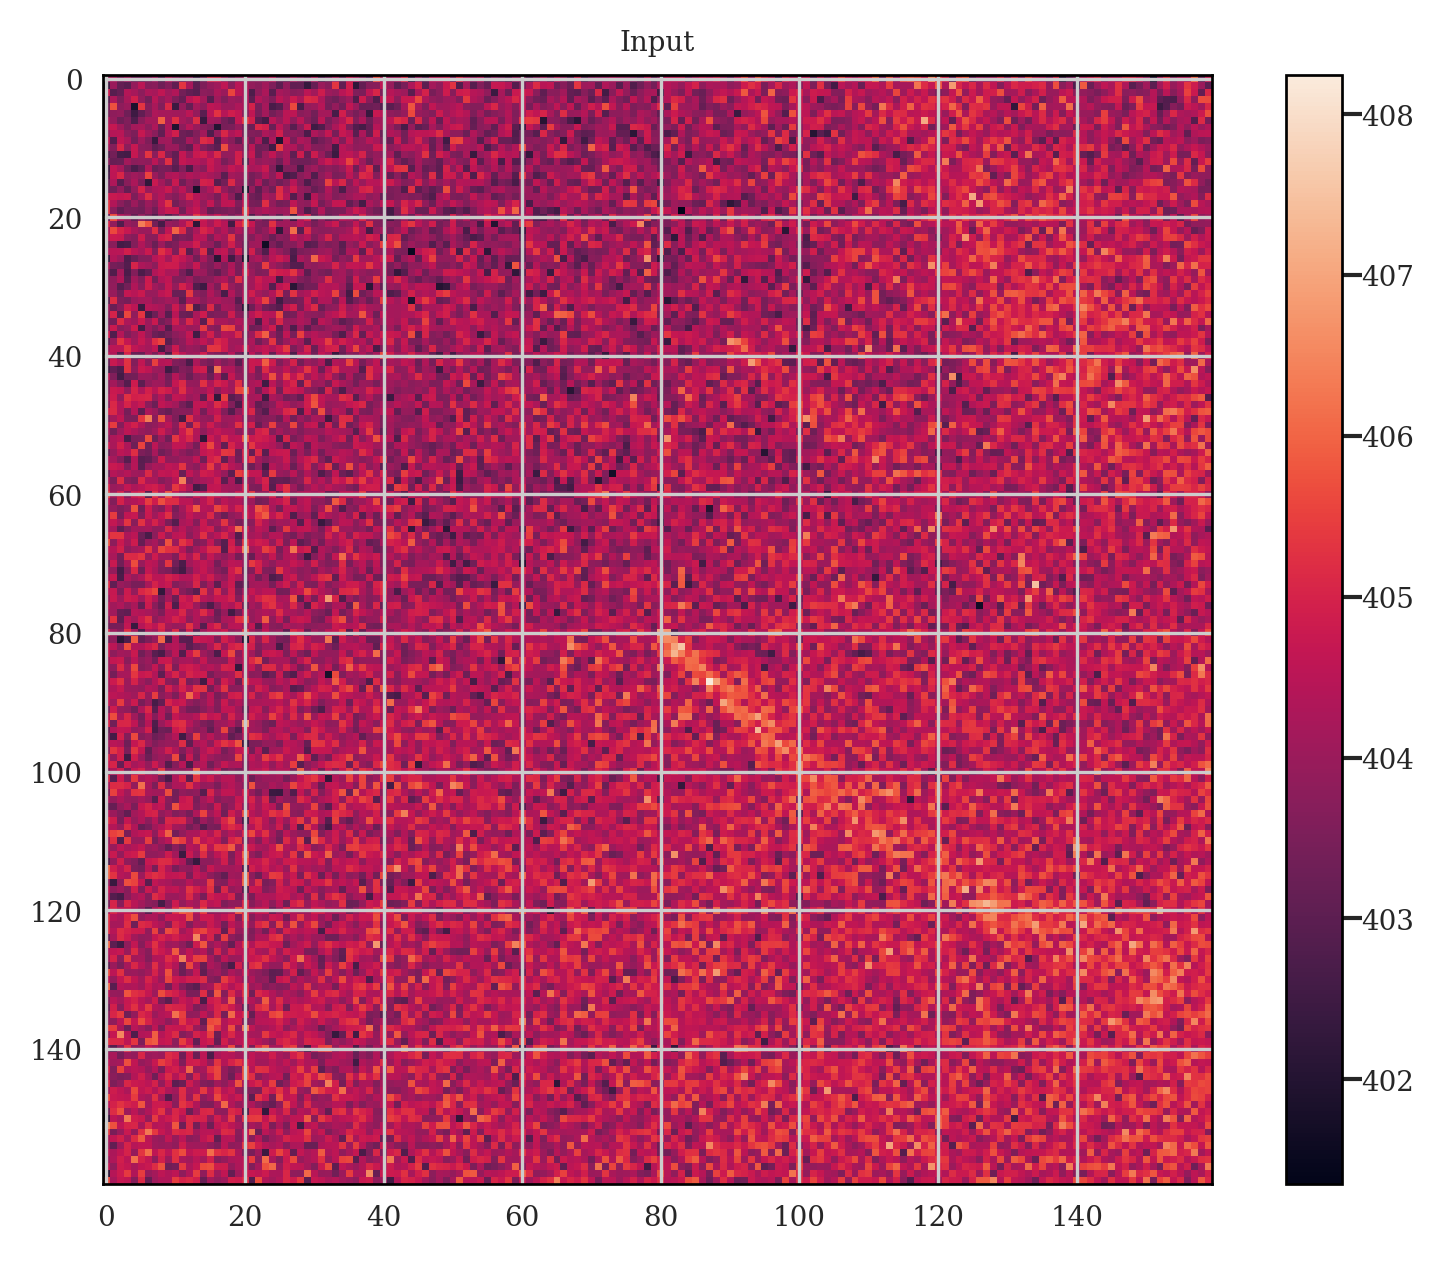

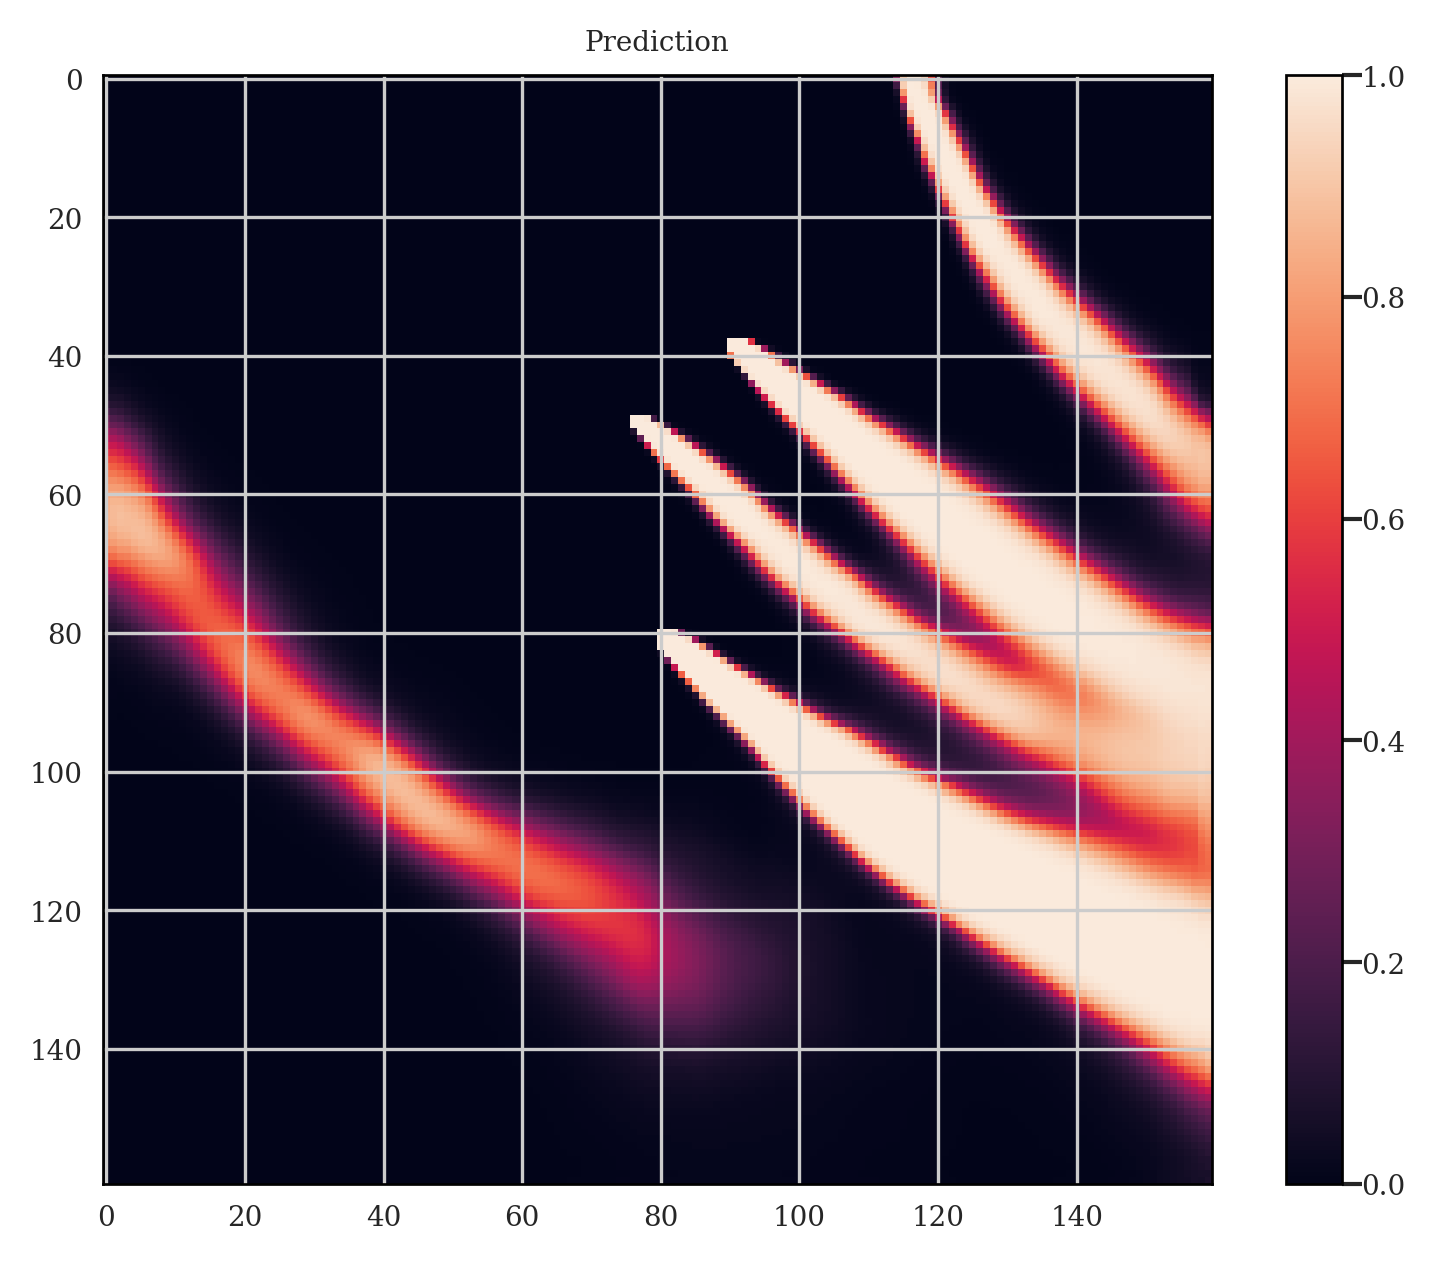

In [97]:
print(model.compute_loss(y=y_test[idx:idx+1], y_pred=pred_test[idx:idx+1]).numpy())

plt.figure()
plt.imshow(np.squeeze(data.y.trace_valid[idx]))
plt.colorbar()
plt.title("Plume")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-trace.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(np.where(data.y.trace_valid[idx]>0.05,1,0)))
plt.colorbar()
plt.title("Segmentation")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-seg.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(data.y.valid[idx]))
plt.colorbar()
plt.title("Truth")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-truth.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(xco2_valid[idx]))
plt.colorbar()
plt.title("All fluxes")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-xco2.png"), transparent=True)


plt.figure()
plt.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[idx])))
plt.colorbar()
plt.title("Input")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-input.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx], 0))[0]))
plt.colorbar()
plt.title("Prediction")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-pred.png"), transparent=True)


### Save with indices, individual plots

0.04097846


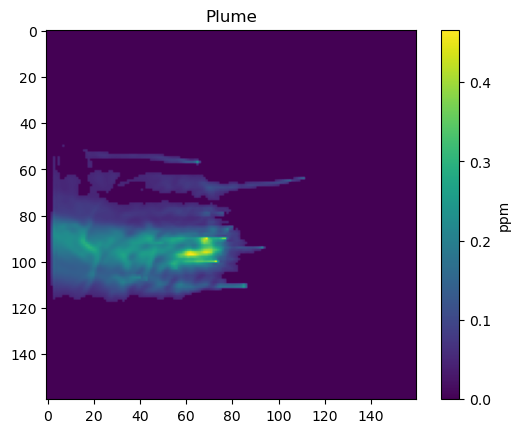

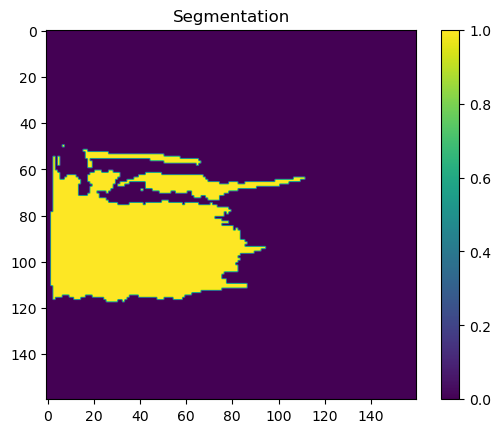

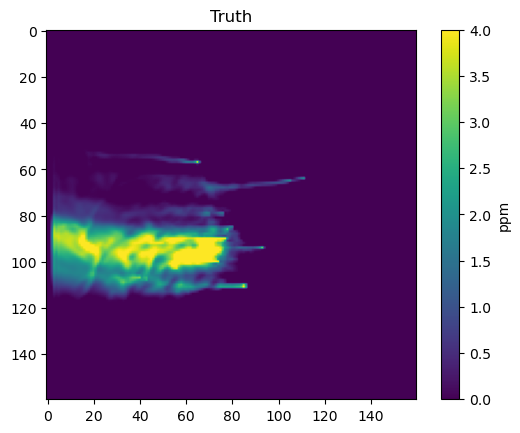

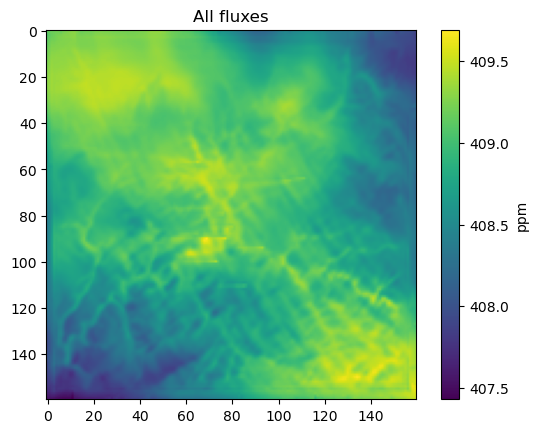

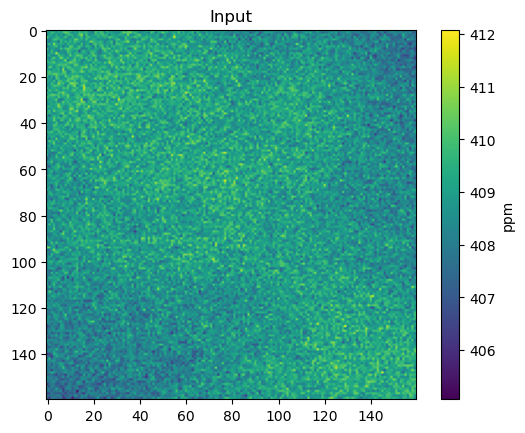

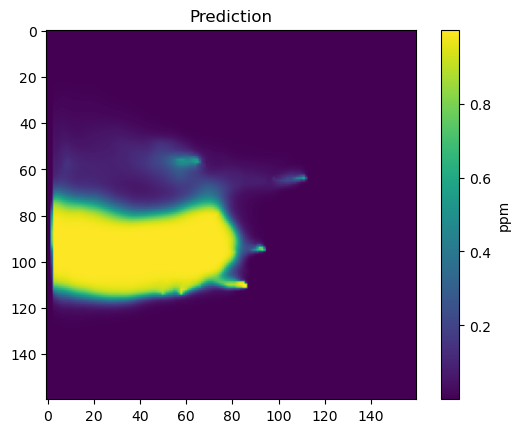

In [184]:
print(model.compute_loss(y=y_test[idx:idx+1], y_pred=pred_test[idx:idx+1]).numpy())

plt.figure()
plt.imshow(np.squeeze(data.y.trace_valid[idx]))
cbar = plt.colorbar()
plt.title("Plume")
cbar.set_label('ppm')
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-trace%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(np.where(data.y.trace_valid[idx]>0.05,1,0)))
plt.colorbar()
plt.title("Segmentation")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-seg%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(data.y.valid[idx]))
cbar = plt.colorbar()
plt.title("Truth")
cbar.set_label('ppm')
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-truth%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(xco2_valid[idx]))
cbar = plt.colorbar()
plt.title("All fluxes")
cbar.set_label('ppm')
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-xco2%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[idx])))
cbar = plt.colorbar()
plt.title("Input")
cbar.set_label('ppm')
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-input%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx], 0))[0]))
cbar = plt.colorbar()
plt.title("Prediction")
cbar.set_label('ppm')
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-pred%s.png"%idx), transparent=True)

In [66]:
config_weights = TreeConfigParser()
config_weights.readfiles(os.path.join(dir_res, weights, "config.cfg"))
weights_ds = config_weights.get("data.directory.name")
dir_fig = os.path.join("eval/fig/seg", weights_ds)
if not os.path.exists(dir_fig):
    os.makedirs(dir_fig)

In [59]:
idx0 = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
print(model.compute_loss(y=y_test[idx0:idx0+1], y_pred=pred_test[idx0:idx0+1]).numpy())

0.107734226


In [53]:
idx1 = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
print(model.compute_loss(y=y_test[idx1:idx1+1], y_pred=pred_test[idx1:idx1+1]).numpy())

0.112643786


eval/fig/seg/LS_pPGIBPP/paper_seg_wLS_pPGIBPP_dsLS_pPGIBPP_i294_i603.png


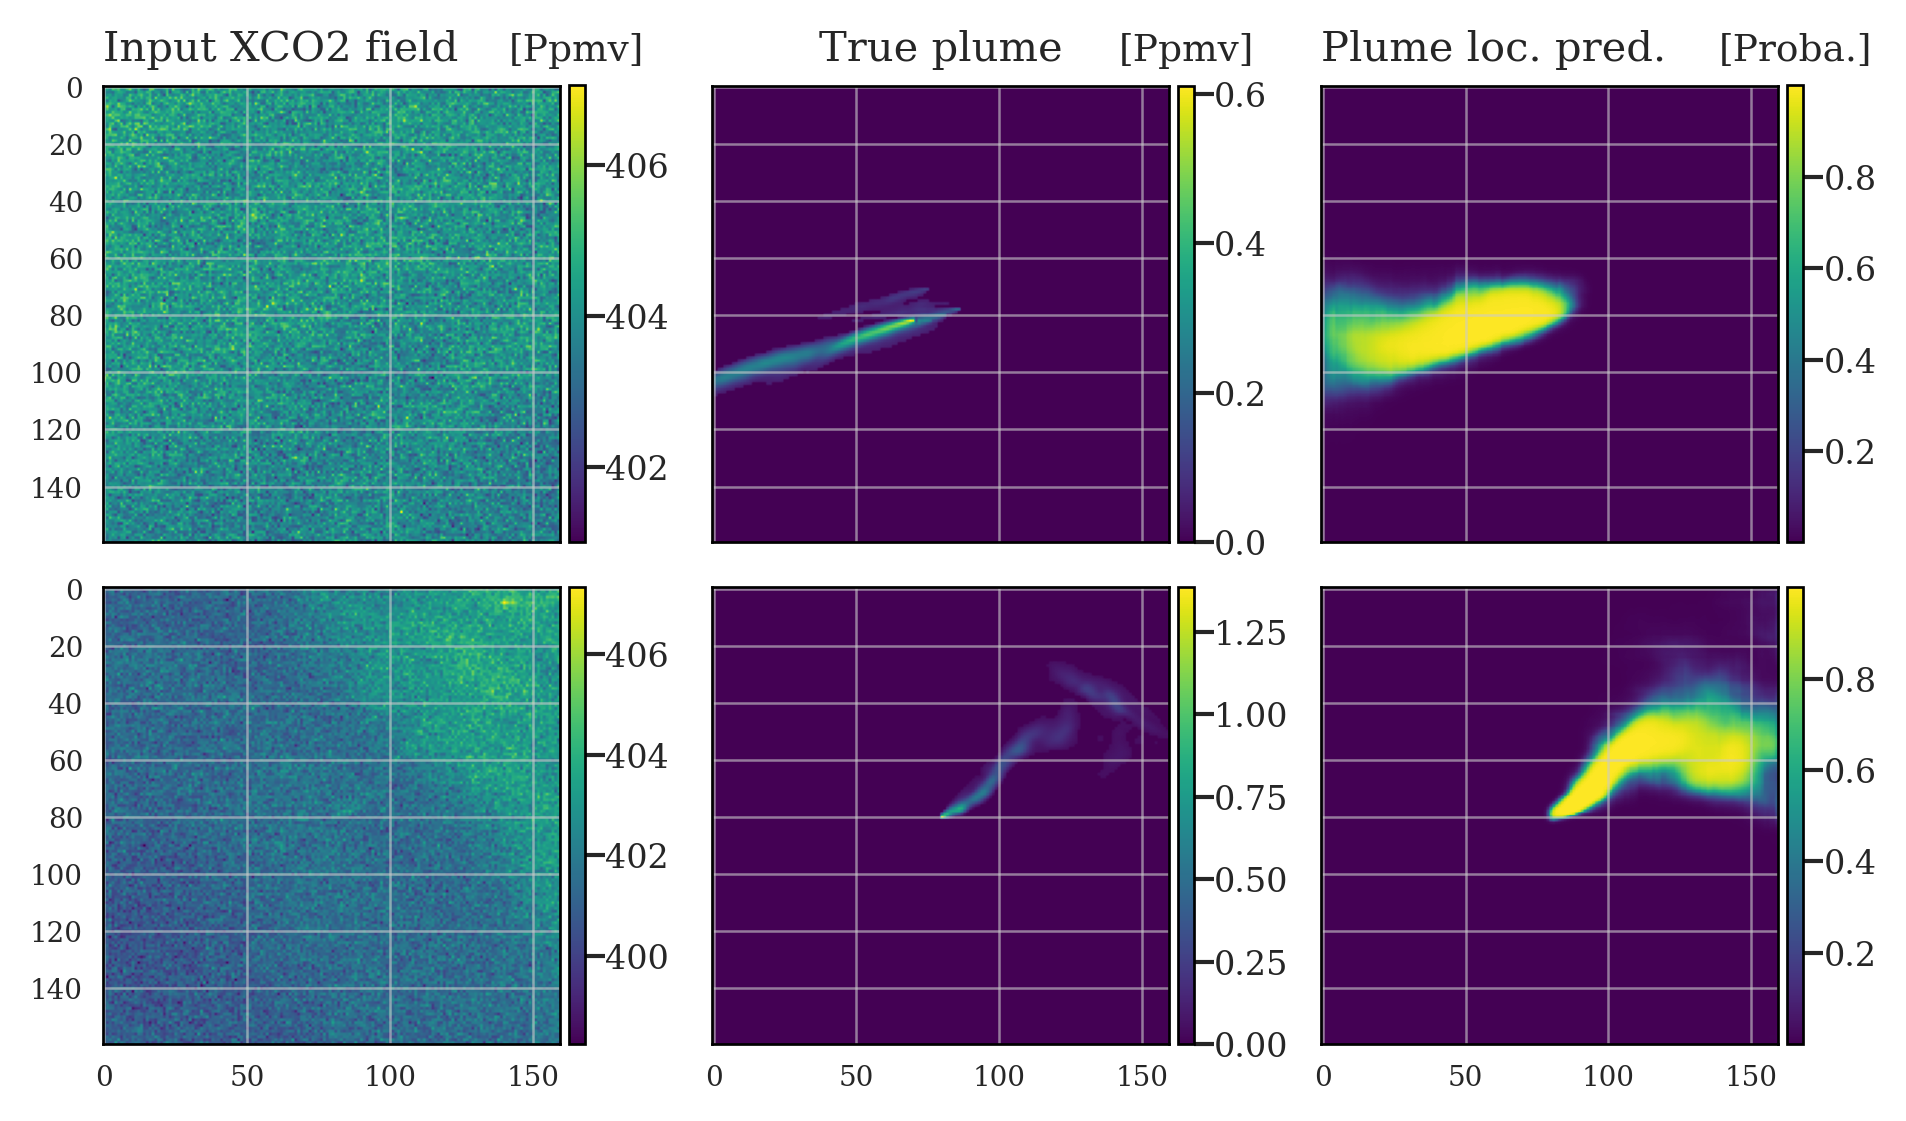

In [68]:
axs = matplotlib_functions.set_figure_axs(2, 3, wratio=0.35, hratio=0.75, pad_w_ext_left=0.25, pad_w_ext_right=0.25, pad_w_int=0.001, pad_h_ext=0.2, pad_h_int=0.15)
[ax0, ax1, ax2, ax3, ax4, ax5] = axs

im0 = ax0.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[idx0])))
ax0.set_xticklabels([])
cax0 = ax0.inset_axes((1.02, 0, 0.035, 1))
cbar0 = plt.colorbar(im0, cax0, orientation="vertical")
cbar0.ax.tick_params(labelsize="8")
cbar0.ax.set_title('[Ppmv]', size=9)
ax0.set_title("Input XCO2 field", loc="left", size=10)

im1 = ax1.imshow(np.squeeze(data.y.plume_valid[idx0]))
ax1.set_xticklabels([])
ax1.set_yticklabels([])
cax1 = ax1.inset_axes((1.02, 0, 0.035, 1))
cbar1 = plt.colorbar(im1, cax1, orientation="vertical")
cbar1.ax.tick_params(labelsize="8")
cbar1.ax.set_title('[Ppmv]', size=9)
ax1.set_title("True plume", size=10)

im2 = ax2.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx0], 0))[0]))
ax2.set_xticklabels([])
ax2.set_yticklabels([])
cax2 = ax2.inset_axes((1.02, 0, 0.035, 1))
cbar2 = plt.colorbar(im2, cax2, orientation="vertical")
cbar2.ax.tick_params(labelsize="8")
cbar2.ax.set_title('[Proba.]', size=9)
ax2.set_title("Plume loc. pred.", loc="left", size=10)

im3 = ax3.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[idx1])))
cax3 = ax3.inset_axes((1.02, 0, 0.035, 1))
cbar3 = plt.colorbar(im3, cax3, orientation="vertical")
cbar3.ax.tick_params(labelsize="8")

im4 = ax4.imshow(np.squeeze(data.y.plume_valid[idx1]))
ax4.set_yticklabels([])
cax4 = ax4.inset_axes((1.02, 0, 0.035, 1))
cbar4 = plt.colorbar(im4, cax4, orientation="vertical")
cbar4.ax.tick_params(labelsize="8")


im5 = ax5.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx1], 0))[0]))
ax5.set_yticklabels([])
cax5 = ax5.inset_axes((1.02, 0, 0.035, 1))
cbar5 = plt.colorbar(im5, cax5, orientation="vertical")
cbar5.ax.tick_params(labelsize="8")

plt.savefig(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"), transparent=True)
print(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"))

eval/fig/seg/LS_pPGIPW/paper_wLS_pPGIPW_dsLS_pPGIPW_i520_i1055.png


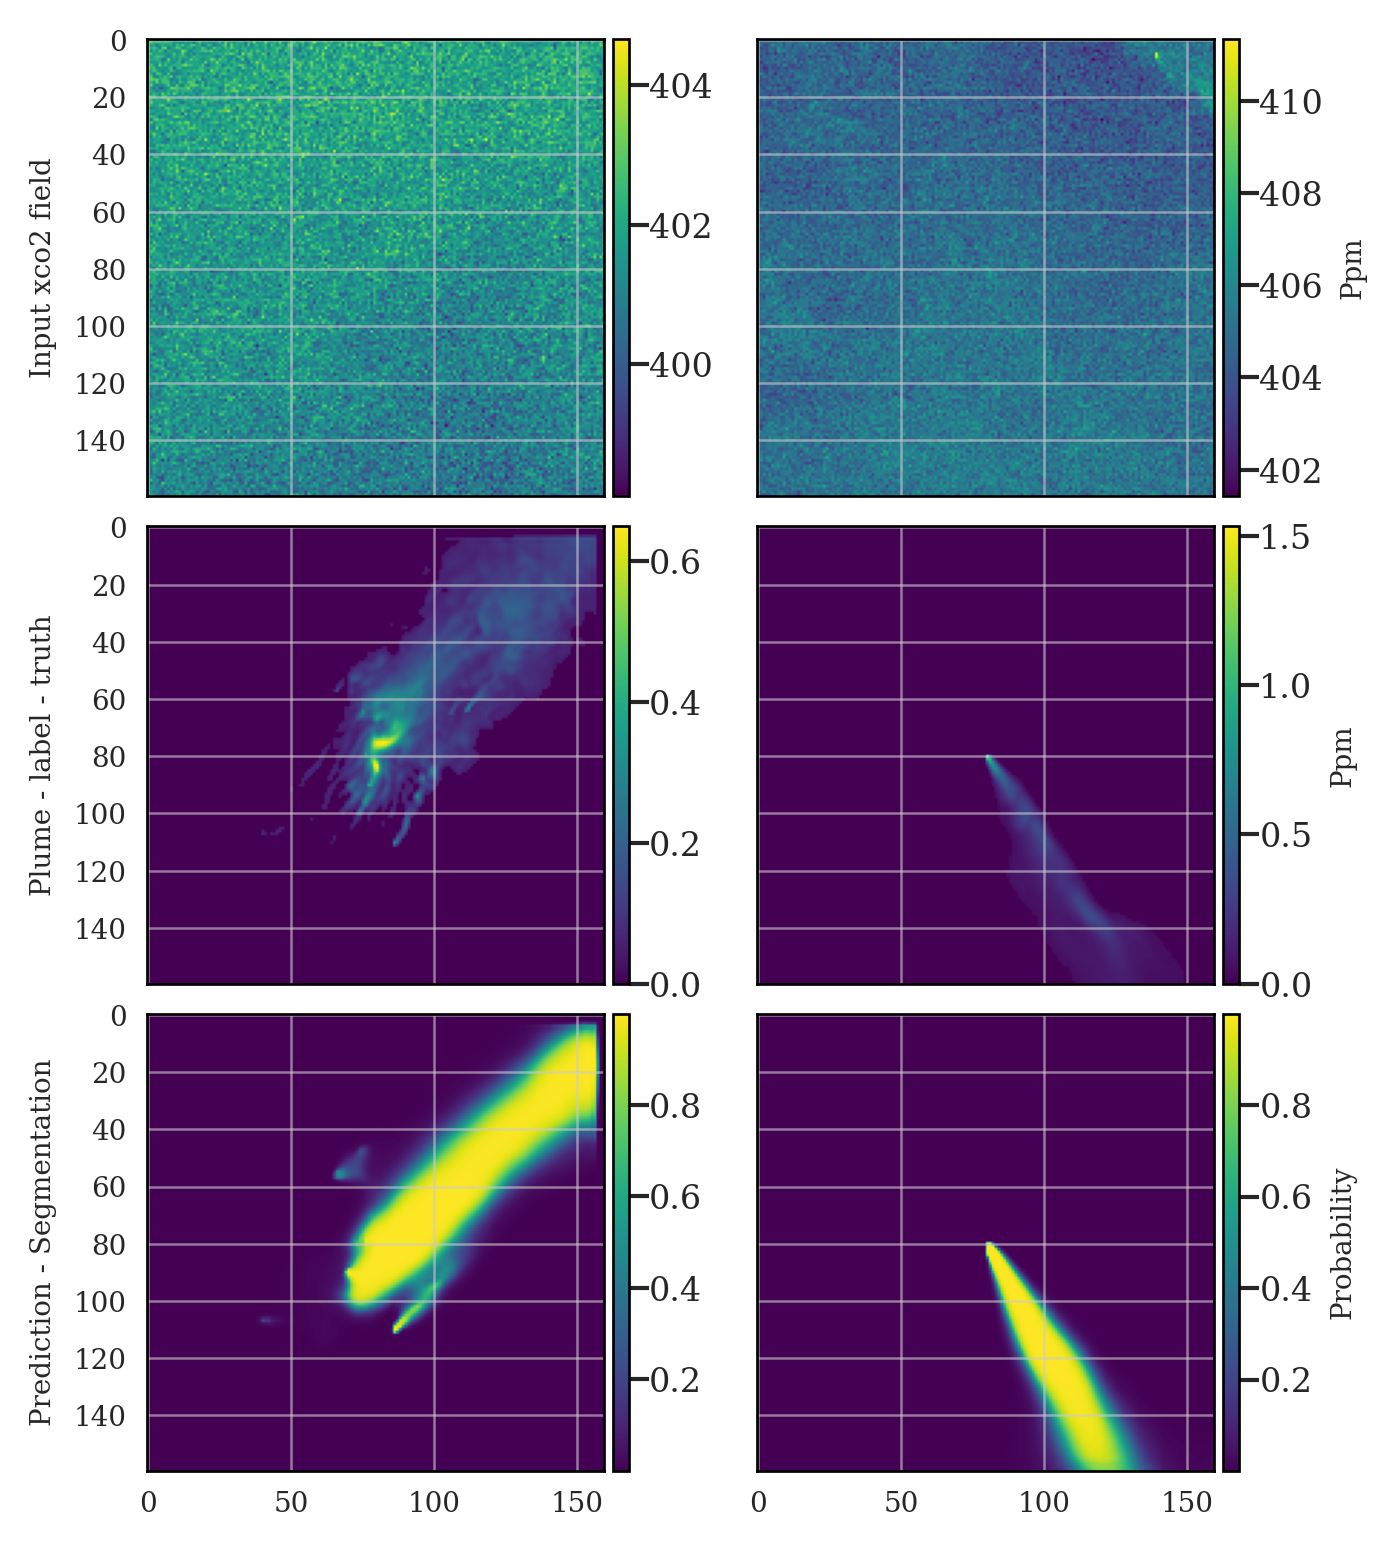

In [355]:
# create figure and ax
figure      = plt.figure(figsize=(fig_w, fig_h))
ax1         = figure.add_axes([ax1_x, ax1_y, ax_dx, ax_dy])
ax2         = figure.add_axes([ax2_x, ax1_y, ax_dx, ax_dy])
ax3         = figure.add_axes([ax1_x, ax2_y, ax_dx, ax_dy])
ax4         = figure.add_axes([ax2_x, ax2_y, ax_dx, ax_dy])
ax5         = figure.add_axes([ax1_x, ax3_y, ax_dx, ax_dy])
ax6         = figure.add_axes([ax2_x, ax3_y, ax_dx, ax_dy])
axs         = [ax1,ax2,ax3,ax4,ax5,ax6]

ax1.set_ylabel("Input xco2 field")
im1 = ax1.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[idx0])))
ax1.set_xticklabels([])
cax1 = ax1.inset_axes((1.02, 0, 0.035, 1))
cbar1 = plt.colorbar(im1, cax1, orientation="vertical")
cbar1.ax.tick_params(labelsize="8")

im2 = ax2.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[idx1])))
ax2.set_xticklabels([])
ax2.set_yticklabels([])
cax2 = ax2.inset_axes((1.02, 0, 0.035, 1))
cbar2 = plt.colorbar(im2, cax2, orientation="vertical", label="Ppm")
cbar2.ax.tick_params(labelsize="8")

ax3.set_ylabel("Plume - label - truth")
im3 = ax3.imshow(np.squeeze(data.y.trace_valid[idx0]))
ax3.set_xticklabels([])
cax3 = ax3.inset_axes((1.02, 0, 0.035, 1))
cbar3 = plt.colorbar(im3, cax3, orientation="vertical")
cbar3.ax.tick_params(labelsize="8")

im4 = ax4.imshow(np.squeeze(data.y.trace_valid[idx1]))
ax4.set_xticklabels([])
ax4.set_yticklabels([])
cax4 = ax4.inset_axes((1.02, 0, 0.035, 1))
cbar4 = plt.colorbar(im4, cax4, orientation="vertical", label="Ppm")
cbar4.ax.tick_params(labelsize="8")

ax5.set_ylabel("Prediction - Segmentation")
im5 = ax5.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx0], 0))[0]))
cax5 = ax5.inset_axes((1.02, 0, 0.035, 1))
cbar5 = plt.colorbar(im5, cax5, orientation="vertical")
cbar5.ax.tick_params(labelsize="8")


im6 = ax6.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx1], 0))[0]))
ax6.set_yticklabels([])
cax6 = ax6.inset_axes((1.02, 0, 0.035, 1))
cbar6 = plt.colorbar(im6, cax6, orientation="vertical", label="Probability")
cbar6.ax.tick_params(labelsize="8")

plt.savefig(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"))
print(os.path.join(dir_fig, f"paper_seg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"))

In [192]:
    ax1.set_ylabel ('Density')
    ax1.text(0.05, 0.94, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    leg = ax1.legend(loc='best', prop={'size': 4.5})
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    ax1.set_xlim (0,0.16)
    ax1.set_xlim(w_min, w_max)
    ax1.set_xticks(tcks)
    ax1.set_xticklabels(lbls)


No handles with labels found to put in legend.


NameError: name 'w_min' is not defined

In [ ]:
idx = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
print(model.compute_loss(y=y_test[idx:idx+1], y_pred=pred_test[idx:idx+1]).numpy())

plt.figure()
plt.imshow(np.squeeze(data.y.trace_valid[idx]))
plt.colorbar()
plt.title("Plume")

plt.figure()
plt.imshow(np.squeeze(np.where(data.y.trace_valid[idx]>0.05,1,0)))
plt.colorbar()
plt.title("Segmentation")

plt.figure()
plt.imshow(np.squeeze(data.y.valid[idx]))
plt.colorbar()
plt.title("Truth")

plt.figure()
plt.imshow(np.squeeze(xco2_valid[idx]))
plt.colorbar()
plt.title("All fluxes")

plt.figure()
plt.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[idx])))
plt.colorbar()
plt.title("Input")

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[idx], 0))[0]))
plt.colorbar()
plt.title("Prediction")
plt.savefig(os.path.join(dir_fig, data.name_dataset + "-pred.png"), transparent=True)


In [305]:
def general_loss(choice):
    losses = {"MeanSquaredLogarithmicError": tf.keras.losses.MeanSquaredLogarithmicError()}
    loss_chosen = losses["MeanSquaredLogarithmicError"]
    def loss(y_true,y_pred):
        return loss_chosen(y_true, y_pred)
    return loss

In [306]:
loss = general_loss("MeanSquaredLogarithmicError")

In [311]:
y_true = [2.] ; y_pred = [3.]

In [312]:
loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.08276097>

In [ ]:


im1 = axs[1].imshow(scaler.inverse_transform(np.squeeze(data.x.test[idx1])))
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
cax1 = axs[1].inset_axes((1.02, 0, 0.035, 1))
cbar1 = plt.colorbar(im1, cax1, orientation="vertical", label="Input XCO2 [ppmv]")
cbar1.ax.tick_params(labelsize="8")

im2 = axs[2].imshow(np.squeeze(data.y.test[idx0]))
axs[2].set_xticklabels([])
cax2 = axs[2].inset_axes((1.02, 0, 0.035, 1))
cbar2 = plt.colorbar(im2, cax2, orientation="vertical")
cbar2.ax.tick_params(labelsize="8")

im3 = axs[3].imshow(np.squeeze(data.y.test[idx1]))
axs[3].set_xticklabels([])
axs[3].set_yticklabels([])
cax3 = axs[3].inset_axes((1.02, 0, 0.035, 1))
cbar3 = plt.colorbar(im3, cax3, orientation="vertical", label="Weighted Boolean")
cbar3.ax.tick_params(labelsize="8")

im4 = axs[4].imshow(np.squeeze(model(tf.expand_dims(data.x.test[idx0], 0))[0]), 
                    vmin=0, vmax=1, cmap = cm.cork)
cax4 = axs[4].inset_axes((1.02, 0, 0.035, 1))
cbar4 = plt.colorbar(im4, cax4, orientation="vertical")
cbar4.ax.tick_params(labelsize="8")


im5 = axs[5].imshow(np.squeeze(model(tf.expand_dims(data.x.test[idx1], 0))[0]), 
                    vmin=0, vmax=1, cmap = cm.cork)
axs[5].set_yticklabels([])
cax5 = axs[5].inset_axes((1.02, 0, 0.035, 1))
cbar5 = plt.colorbar(im5, cax5, orientation="vertical", label="Prediction [probability]")
cbar5.ax.tick_params(labelsize="8")